# requirements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from src.load_data import load_data

save_path = "/Users/ppopov1/adm-proj/data/pyspi_proc/"
families = ["cov_", "cov-sq_", "prec_"]

fbirn_data, demographics = load_data()
timeseries = fbirn_data["data"]
diagnoses = fbirn_data["diags"]
sexes = fbirn_data["sexes"]
ages = fbirn_data["ages"]

print(demographics)
print(f"# subjects: {timeseries.shape[0]}, # timepoints: {timeseries.shape[1]}, # features: {timeseries.shape[2]}")

     Category          Statistic/Label   Value
0   Diagnosis             Count HC (0)  160.00
1   Diagnosis             Count SZ (1)  151.00
2         Sex           Count Male (0)  230.00
3         Sex         Count Female (1)   81.00
4         Age                      Min   18.00
5         Age                      Max   62.00
6         Age                     Mean   37.88
7         Age                  Std Dev   11.24
8    Age Bins  Count Bin 0 (18.0-32.7)  119.00
9    Age Bins  Count Bin 1 (32.7-47.3)  117.00
10   Age Bins  Count Bin 2 (47.3-62.0)   75.00
# subjects: 311, # timepoints: 140, # features: 53


In [2]:
ica_coords = pd.read_csv("data/ICN_coordinates.csv")
domains = ica_coords["Domain"]
# update nans with previous value
domains = domains.fillna(method='ffill')
domains = np.asarray(domains.tolist())

change_idx = np.flatnonzero(np.r_[True, domains[1:] != domains[:-1]])
# change_idx marks the start index of each group
starts = change_idx
# compute ends (inclusive) indices for each group
ends = np.r_[starts[1:] - 1, domains.size - 1]
centers = ((starts + ends) / 2.0).tolist()
# boundaries are positions between pixels: (end + 0.4) for each group except last
boundaries = (ends[:-1] + 0.4).tolist()

group_names_full = [domains[s] for s in starts]
group_names = ["SC", "AU", "SM", "VIS", "CC", "DM", "CB"]  # short names

/var/folders/c7/h35llrbd2h76sn_0f75rjyz00000gq/T/ipykernel_46583/2963762152.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  domains = domains.fillna(method='ffill')


# 0. First milestone
- Write a general setup for the experiments
- Find important features using stattests 
- Train classifiers, inspect the features that they found important

## derive PCC

In [4]:
from src.utils import corrcoef_batch

pcc_matrices = corrcoef_batch(timeseries)
pcc_matrices.shape

(311, 53, 53)

## run stat tests on the data

In [3]:
def ttest(data0, data1):
    stat, p_value = stats.ttest_ind(data0, data1, axis=0, equal_var=False)
    return stat, p_value

def analyze_group_differences(data, labels, stat_func = ttest, fdr=True, p_threshold=0.05):
    groups = np.unique(labels)

    C = data.shape[1]
    tril_indices = np.tril_indices(data.shape[1], k=-1)
    X = data[:, tril_indices[0], tril_indices[1]]
    n_samples = X.shape[0]
    X = X.reshape(n_samples, -1)

    group_data = [X[labels == g] for g in groups]

    stat, p_value = stat_func(group_data[0], group_data[1])
    if fdr:
        p_threshold = p_threshold/p_value.shape[0]
    p_thresh = (p_value < p_threshold).astype(int)

    # reshape importances back to matrix form
    full_stat, full_p_value, full_p_thresh = np.zeros((C, C)), np.zeros((C, C)), np.zeros((C, C))
    full_stat[tril_indices], full_p_value[tril_indices], full_p_thresh[tril_indices] = stat, p_value, p_thresh
    full_stat, full_p_value, full_p_thresh = full_stat + full_stat.T, full_p_value + full_p_value.T, full_p_thresh + full_p_thresh.T
    stat, p_value, p_thresh = full_stat, full_p_value, full_p_thresh

    # #######
    # group_data = [data[labels == g] for g in groups]

    # stat, p_value = stat_func(group_data[0], group_data[1])
    # if fdr:
    #     print(data.shape[1]*data.shape[2])
    #     p_threshold = p_threshold/data.shape[1]
    # p_thresh = (p_value < p_threshold).astype(int)
    # #######

    return stat, p_value, p_thresh.astype(bool)

def plot_heatmap(matrix, ax, cmap='bwr', vmin=None, vmax=None, guides_color='k'):
    cax = ax.imshow(matrix, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xticks(centers)
    ax.set_xticklabels(group_names)
    ax.set_yticks(centers)
    ax.set_yticklabels(group_names)
    for boundary in boundaries:
        ax.axhline(boundary, color=guides_color, linewidth=1.5)
        ax.axvline(boundary, color=guides_color, linewidth=1.5)
    return cax

def plot_stats(stat, p_vals, p_thresh, title=""):
    fig, ax = plt.subplots(1, 3, figsize=(14, 5))
    cax1 = plot_heatmap(stat, ax[0], vmin=-5, vmax=5)
    ax[0].set_title("T-statistics" if title == "" else f"T-statistics ({title})")
    fig.colorbar(cax1, ax=ax[0], fraction=0.045)  

    cax2 = plot_heatmap(p_vals, ax[1], vmin=0, vmax=1, cmap='inferno_r')
    ax[1].set_title("p-values")
    fig.colorbar(cax2, ax=ax[1], fraction=0.045)  

    cax3 = plot_heatmap(p_thresh, ax[2], vmin=0, vmax=1, cmap='inferno', guides_color='white')
    ax[2].set_title("Significant p-values")
    cbar3 = fig.colorbar(cax3, ax=ax[2], fraction=0.045)
    cbar3.set_ticks([0, 1])
    cbar3.set_ticklabels(['False', 'True'])

    plt.tight_layout()
    plt.show()

def plot_means(data, labels, title="", unit_lim=True):
    groups = np.unique(labels)
    group_data = [data[diagnoses == g] for g in groups]
    means = [np.mean(gd, axis=0) for gd in group_data]

    if unit_lim:
        vmin, vmax = -1, 1
    else:
        vmax = max([np.max(np.abs(m)) for m in means])
        vmin = -vmax
        
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    cax = plot_heatmap(means[0], ax[0], cmap='bwr', vmin=vmin, vmax=vmax)
    fig.colorbar(cax, ax=ax[0], fraction=0.045)
    ax[0].set_title(f"Patients Mean {title}")
    cax = plot_heatmap(means[1], ax[1], cmap='bwr', vmin=vmin, vmax=vmax)
    fig.colorbar(cax, ax=ax[1], fraction=0.045)
    ax[1].set_title(f"Controls Mean {title}")
    plt.tight_layout()
    plt.show()

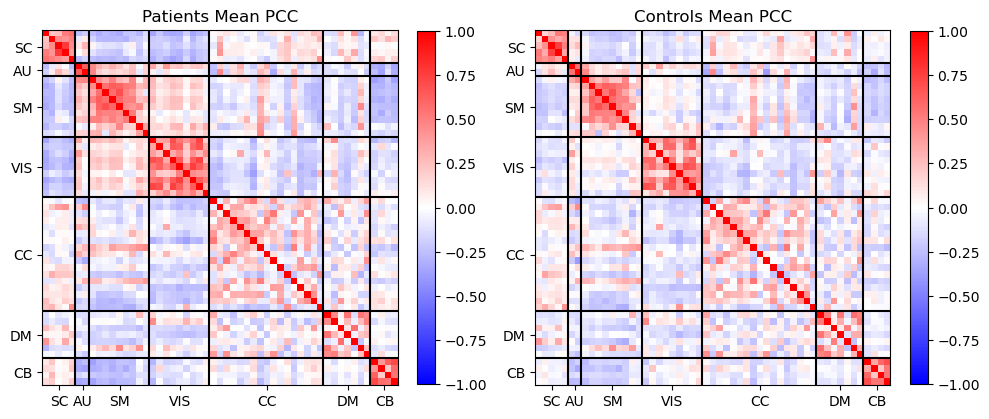

In [6]:
# plot means

plot_means(pcc_matrices, diagnoses, title="PCC")

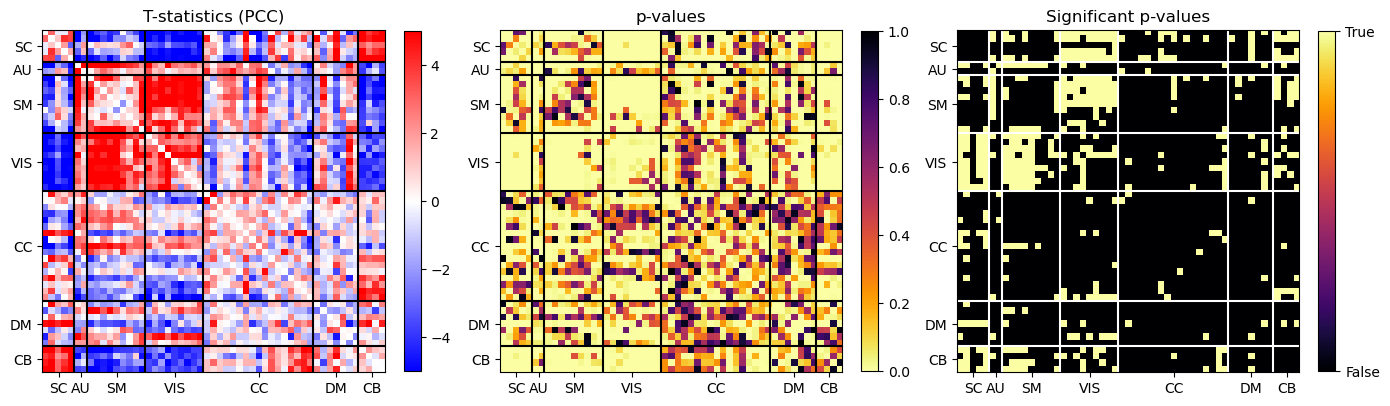

Proportion of significant connections: 0.1737


In [7]:
stat, p_value, p_thresh = analyze_group_differences(pcc_matrices, diagnoses)
# stat, p_value, p_thresh = analyze_group_differences(pcc_matrices, diagnoses, fdr=False)
plot_stats(stat, p_value, p_thresh, title="PCC")

# compute True rate in p_thresh; I will use it as a threhold for ML feature importance selection
r_significant = np.sum(p_thresh)/np.size(p_thresh)
print(f"Proportion of significant connections: {r_significant:.4f}")

## use ML to find predictive features

In [8]:
from sklearn.ensemble import RandomForestClassifier

def forest_features(X, y, n_estimators=1000, threshold=0.5):
    C = X.shape[1]
    tril_indices = np.tril_indices(X.shape[1], k=-1)
    X = X[:, tril_indices[0], tril_indices[1]]
    n_samples = X.shape[0]
    X = X.reshape(n_samples, -1)

    clf = RandomForestClassifier(n_estimators=n_estimators)
    clf.fit(X, y)
    importances = clf.feature_importances_
    # reshape importances back to matrix form
    full_importances = np.zeros((C, C))
    full_importances[tril_indices] = importances
    full_importances = full_importances + full_importances.T
    importances = full_importances

    # get a mask of top k% importances
    # topk_importances = np.percentile(importances, 100 * threshold)
    topk_importances = np.percentile(importances, 100 * (1-threshold))
    # mask = (importances > topk_importances).astype(int)
    mask = (importances > topk_importances).astype(bool)

    return importances, mask

In [9]:
# importances, importance_mask = forest_features(pcc_matrices, diagnoses, threshold=0.05)
importances, importance_mask = forest_features(pcc_matrices, diagnoses, threshold=r_significant)

/var/folders/c7/h35llrbd2h76sn_0f75rjyz00000gq/T/ipykernel_11731/438554083.py:7: RuntimeWarning: divide by zero encountered in log
  cax = plot_heatmap(np.log(feat_importance), ax[1], cmap='inferno', guides_color='white')


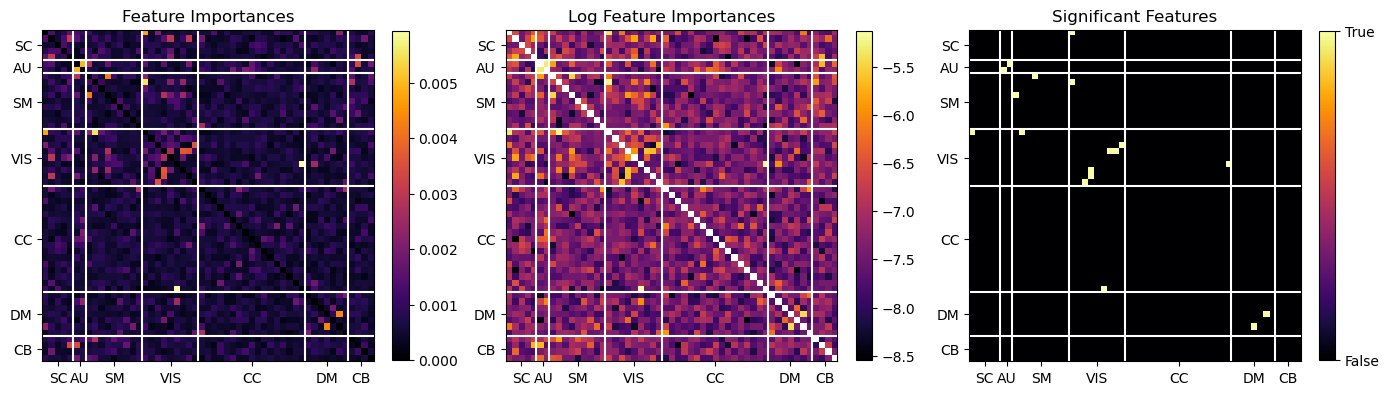

In [27]:
def plot_importances(feat_importance, mask, title=None):

    fig, ax = plt.subplots(1, 3, figsize=(14, 5))
    cax = plot_heatmap(feat_importance, ax[0], cmap='inferno', guides_color='white')
    fig.colorbar(cax, ax=ax[0], fraction=0.045)
    ax[0].set_title("Feature Importances" if title is None else f"{title}: Feature Importances")
    cax = plot_heatmap(np.log(feat_importance), ax[1], cmap='inferno', guides_color='white')
    fig.colorbar(cax, ax=ax[1], fraction=0.045)
    ax[1].set_title("Log Feature Importances" if title is None else f"{title}: Log Feature Importances")

    cax = plot_heatmap(mask, ax[2], cmap='inferno', guides_color='white')
    ax[2].set_title("Significant Features" if title is None else f"{title}: Significant Features")
    cbar3 = fig.colorbar(cax, ax=ax[2], fraction=0.045)
    cbar3.set_ticks([0, 1])
    cbar3.set_ticklabels(['False', 'True'])
    plt.tight_layout()
    plt.show()

plot_importances(importances, importance_mask)

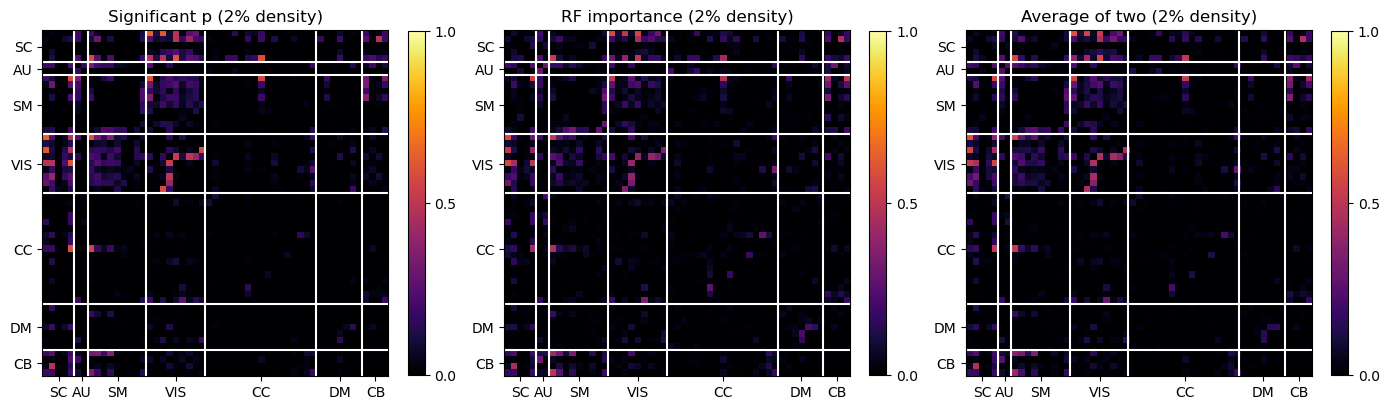

In [21]:
# plot p_thresh and importance_mask, and AND matrix
def plot_and_matrix(stat_p, tree_p, aggregated=False, title=None):
    if not aggregated:
        fig, ax = plt.subplots(1, 3, figsize=(14, 5))
        cax1 = plot_heatmap(stat_p, ax[0], cmap='inferno', guides_color='white')
        sp_p = np.sum(stat_p)/np.size(stat_p)
        ax[0].set_title(f"Significant p ({int(sp_p*100)}% density)" if title is None else f"{title}: Significant p ({int(sp_p*100)}% density)")
        cbar1 = fig.colorbar(cax1, ax=ax[0], fraction=0.045)
        cbar1.set_ticks([0, 1])
        cbar1.set_ticklabels(['F', 'T'])

        cax2 = plot_heatmap(tree_p, ax[1], cmap='inferno', guides_color='white')
        sp_rf = np.sum(tree_p)/np.size(tree_p)
        ax[1].set_title(f"RF importance ({int(sp_rf*100)}% density)" if title is None else f"{title}: RF importance ({int(sp_rf*100)}% density)")
        cbar2 = fig.colorbar(cax2, ax=ax[1], fraction=0.045)
        cbar2.set_ticks([0, 1])
        cbar2.set_ticklabels(['F', 'T'])

        and_matrix = stat_p & tree_p
        sp_and = np.sum(and_matrix)/np.size(and_matrix)
        cax3 = plot_heatmap(and_matrix, ax[2], cmap='inferno', guides_color='white')
        ax[2].set_title(f"AND Matrix ({int(sp_and*100)}% density)" if title is None else f"{title}: AND Matrix ({int(sp_and*100)}% density)")
        cbar3 = fig.colorbar(cax3, ax=ax[2], fraction=0.045)
        cbar3.set_ticks([0, 1])
        cbar3.set_ticklabels(['F', 'T'])
        plt.tight_layout()
        plt.show()
    else:
        fig, ax = plt.subplots(1, 3, figsize=(14, 5))
        cax1 = plot_heatmap(stat_p, ax[0], cmap='inferno', guides_color='white', vmin=0, vmax=1)
        sp_p = np.sum(stat_p)/np.size(stat_p)
        ax[0].set_title(f"Significant p ({int(sp_p*100)}% density)" if title is None else f"{title}: Significant p ({int(sp_p*100)}% density)")
        cbar1 = fig.colorbar(cax1, ax=ax[0], fraction=0.045)
        cbar1.set_ticks([0.0, 0.5, 1.0])
        cbar1.set_ticklabels([0.0, 0.5, 1.0])

        cax2 = plot_heatmap(tree_p, ax[1], cmap='inferno', guides_color='white', vmin=0, vmax=1)
        sp_rf = np.sum(tree_p)/np.size(tree_p)
        ax[1].set_title(f"RF importance ({int(sp_rf*100)}% density)" if title is None else f"{title}: RF importance ({int(sp_rf*100)}% density)")
        cbar2 = fig.colorbar(cax2, ax=ax[1], fraction=0.045)
        cbar2.set_ticks([0.0, 0.5, 1.0])
        cbar2.set_ticklabels([0.0, 0.5, 1.0])

        and_matrix = (stat_p + tree_p)*0.5
        sp_and = np.sum(and_matrix)/np.size(and_matrix)
        cax3 = plot_heatmap(and_matrix, ax[2], cmap='inferno', guides_color='white', vmin=0, vmax=1)
        ax[2].set_title(f"Average of two ({int(sp_and*100)}% density)" if title is None else f"{title}: Average of two ({int(sp_and*100)}% density)")
        cbar3 = fig.colorbar(cax3, ax=ax[2], fraction=0.045)
        cbar3.set_ticks([0.0, 0.5, 1.0])
        cbar3.set_ticklabels([0.0, 0.5, 1.0])
        plt.tight_layout()
        plt.show()

plot_and_matrix(p_thresh, importance_mask, aggregated=True)

# More statistics

I will use pyspi to compute statistics. Check their docummentation: https://time-series-features.gitbook.io/pyspi/installing-and-using-pyspi/usage/walkthrough-tutorials/getting-started-a-simple-demonstration

In [ ]:
from pyspi.calculator import Calculator
import dill

for i, test_subject in enumerate(timeseries):
    test_subject = test_subject.T # pyspi calc expects data in shape [chanels, time]
    calc = Calculator(dataset=test_subject, configfile='./custom_config.yaml') # instantiate the calculator object

    calc.compute()

    # save and load pickle

    save_path = "/Users/ppopov1/adm-proj/data/pyspi/"
    dill.dump(calc, open(save_path+f"pyspi_calc_{i:03d}.pkl", 'wb'))

    # with open(save_path+f"pyspi_calc_{i:03d}.pkl", 'rb') as f:
    #     calc_load = dill.load(f)

In [63]:
from pyspi.calculator import Calculator
import dill
import os
save_path = "/Users/ppopov1/adm-proj/data/pyspi/"

calcs = {}
for file in os.listdir(save_path):
    index = int(file.split("_")[-1].split(".")[0])
    with open(save_path+file, 'rb') as f:
        calcs[index] = dill.load(f)

counter = 0
good_spis = []

for spi_type in calcs[0].spis:
    spi_data = calcs[0].table[spi_type].to_numpy()
    # get values off-diagonal
    off_diag = spi_data[np.triu_indices_from(spi_data, k=1)]
    nans_off_diag = np.isnan(off_diag).any()
    if not nans_off_diag:
        counter += 1
        good_spis.append(spi_type)
    else:
        pass
        # print(F"{spi_type} data has nans off-diagonal: {nans_off_diag}")

print(F"Number of SPI types without nans off-diagonal: {counter} out of {len(calcs[0].spis)}")

save_path = "/Users/ppopov1/adm-proj/data/pyspi_proc/"

ALL_DATA = {}
ALL_DATA["ts"] = timeseries
ALL_DATA["diags"] = diagnoses
ALL_DATA["sexes"] = sexes   
ALL_DATA["ages"] = ages
ALL_DATA["spis"] = good_spis


for spi in good_spis:
    print(spi)
    data = []
    for i in range(len(calcs)):
        spi_data = calcs[i].table[spi].to_numpy()
        off_diag = spi_data[np.triu_indices_from(spi_data, k=1)]
        assert not np.isnan(off_diag).any(), f"NaNs found in subject {i}, SPI {spi}"
        data.append(spi_data)
    data = np.array(data)
    print(data.shape)
    np.save(save_path+f"{spi}.npy", data)
    ALL_DATA[spi] = data

import dill
with open(save_path+"all_data.pkl", 'wb') as f:
    dill.dump(ALL_DATA, f)

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
'cgi' is deprecated and slated for removal in Python 3.13


KeyboardInterrupt: 

In [50]:
# load all data
import dill
with open(save_path+"all_data.pkl", 'rb') as f:
    ALL_DATA = dill.load(f) 

'cov_EmpiricalCovariance',


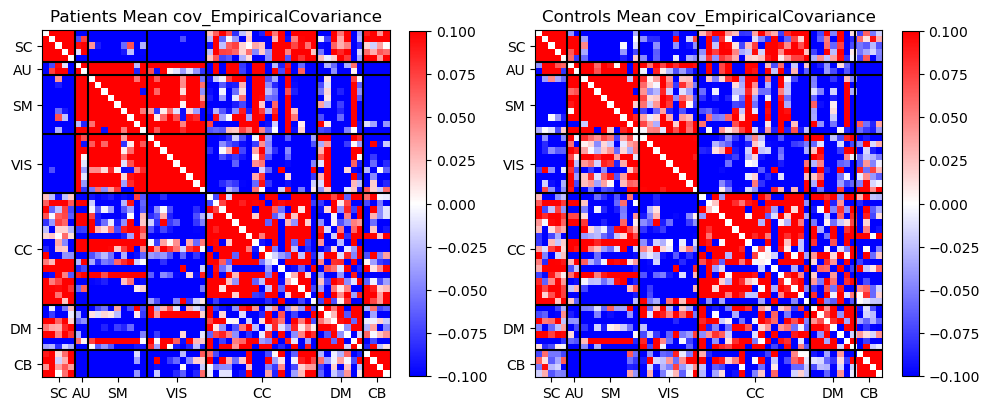

'cov_EllipticEnvelope',


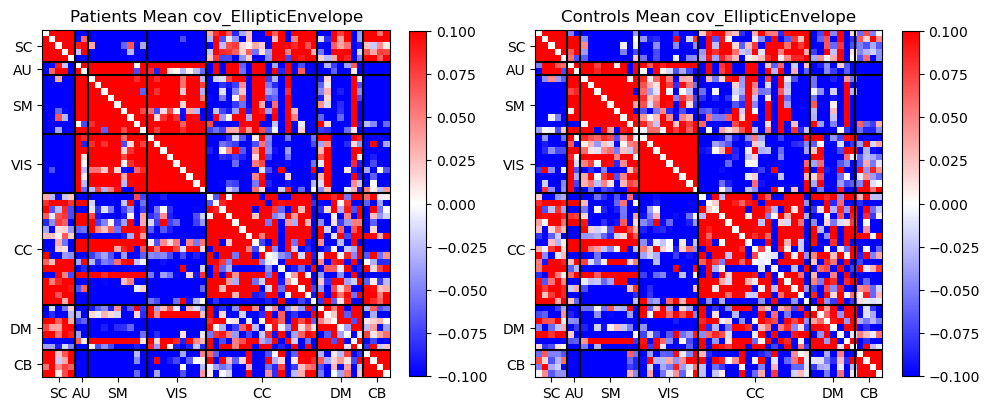

'cov_GraphicalLasso',


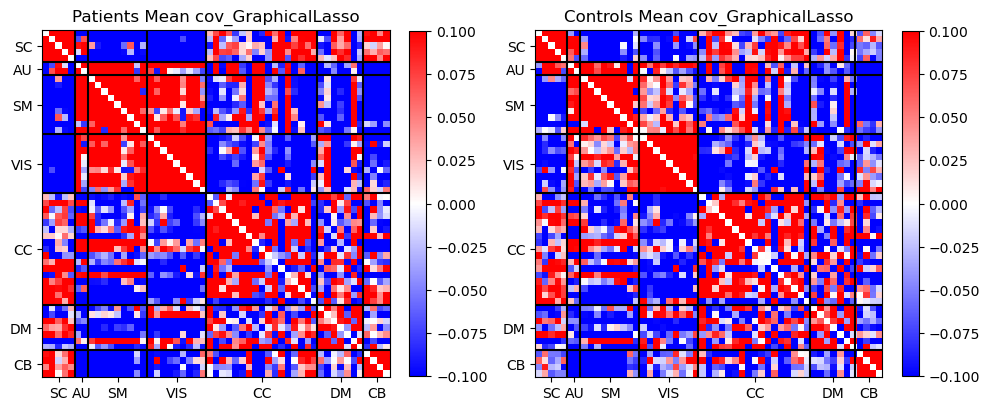

'cov_GraphicalLassoCV',


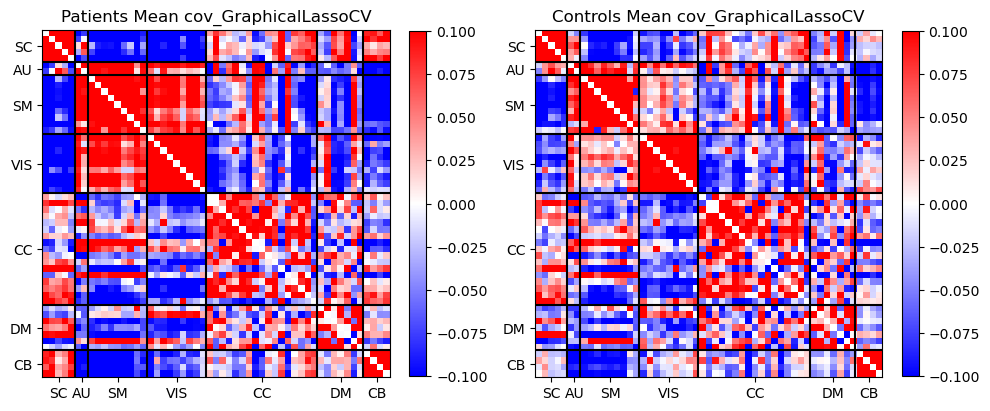

'cov_LedoitWolf',


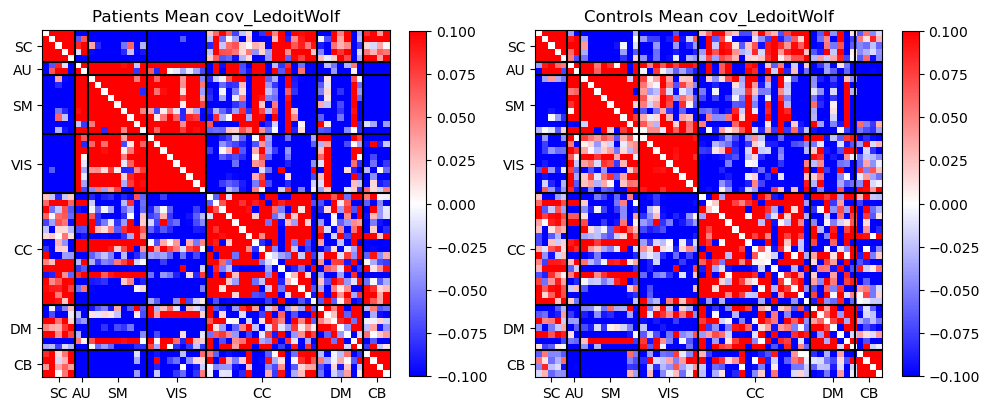

'cov_MinCovDet',


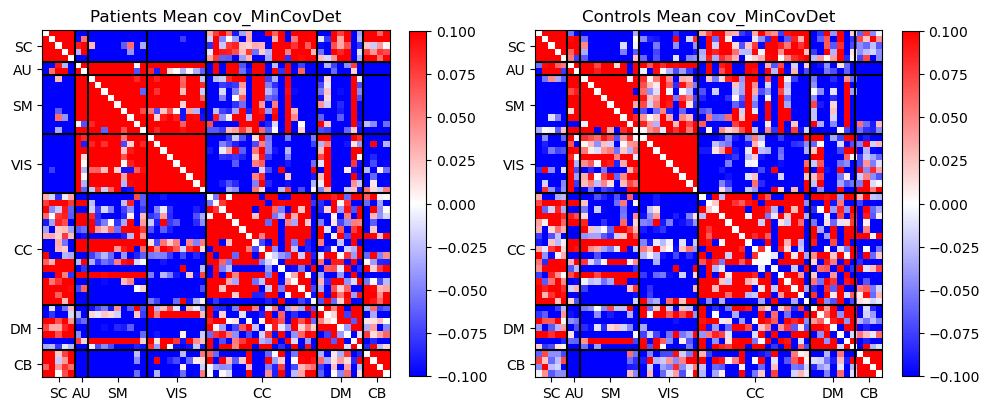

'cov_OAS',


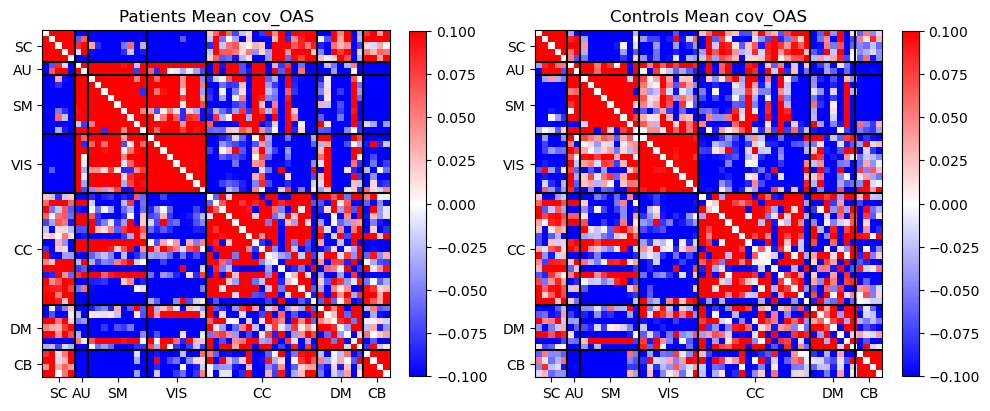

'cov_ShrunkCovariance',


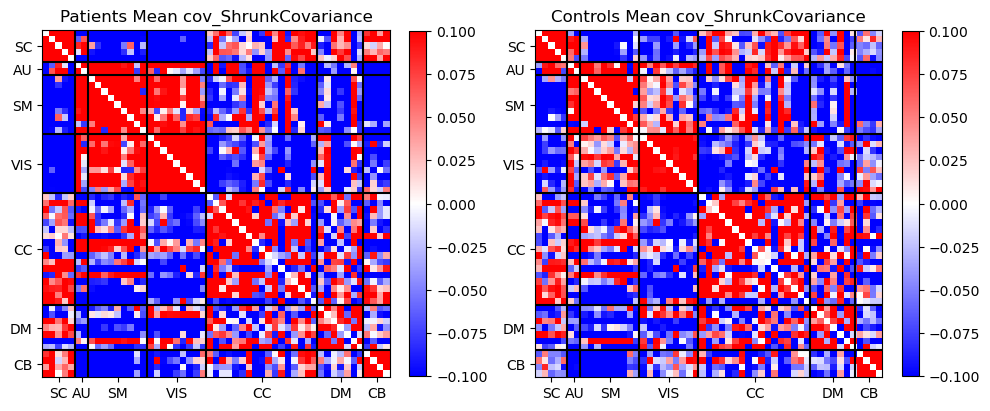

'cov-sq_EmpiricalCovariance',


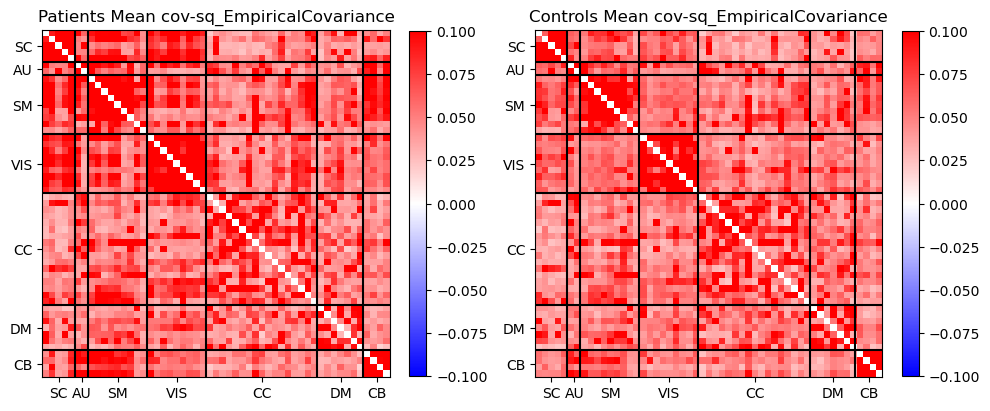

'cov-sq_EllipticEnvelope',


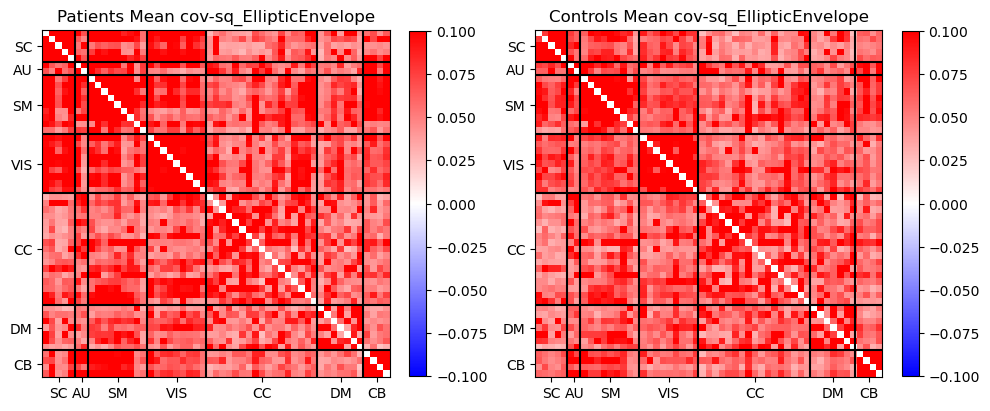

'cov-sq_GraphicalLasso',


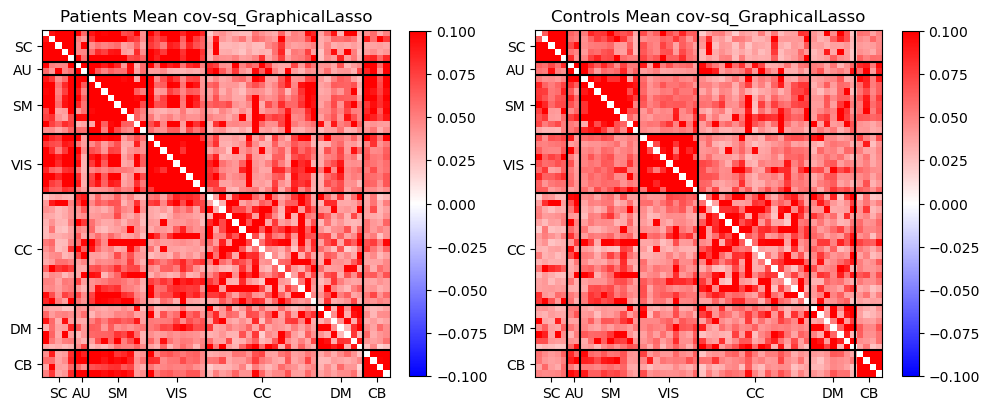

'cov-sq_GraphicalLassoCV',


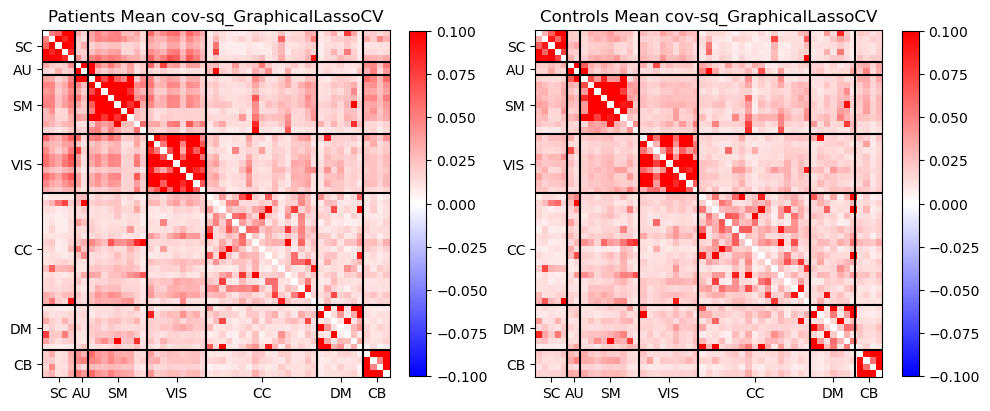

'cov-sq_LedoitWolf',


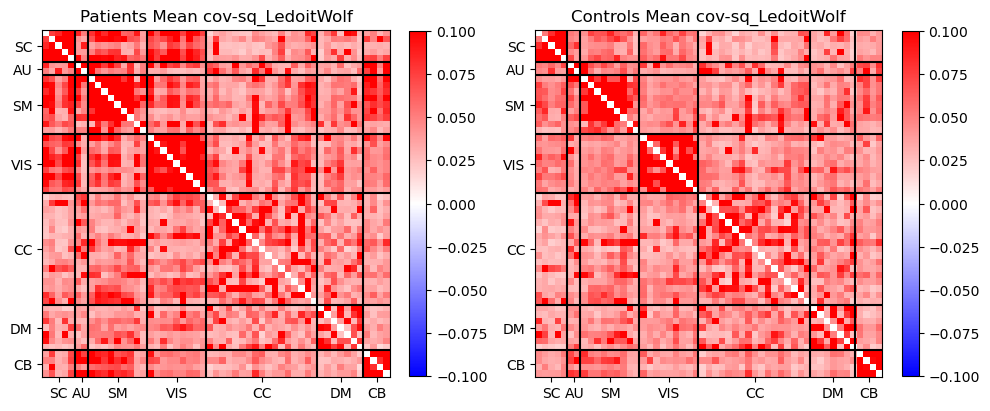

'cov-sq_MinCovDet',


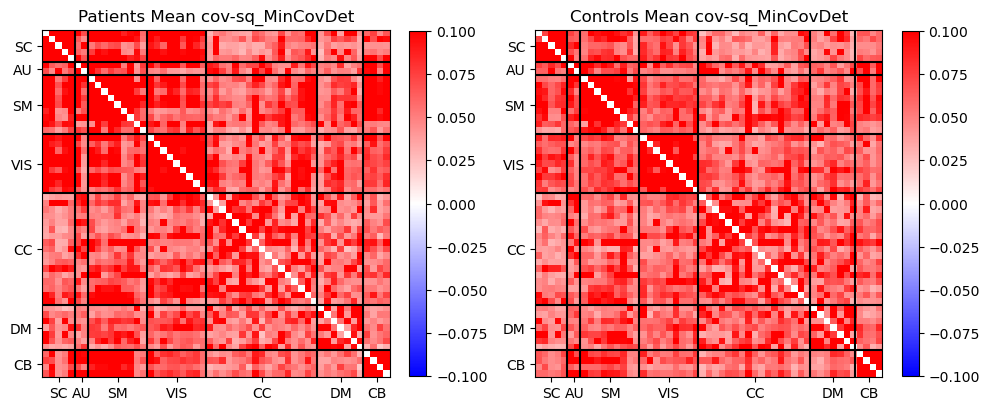

'cov-sq_OAS',


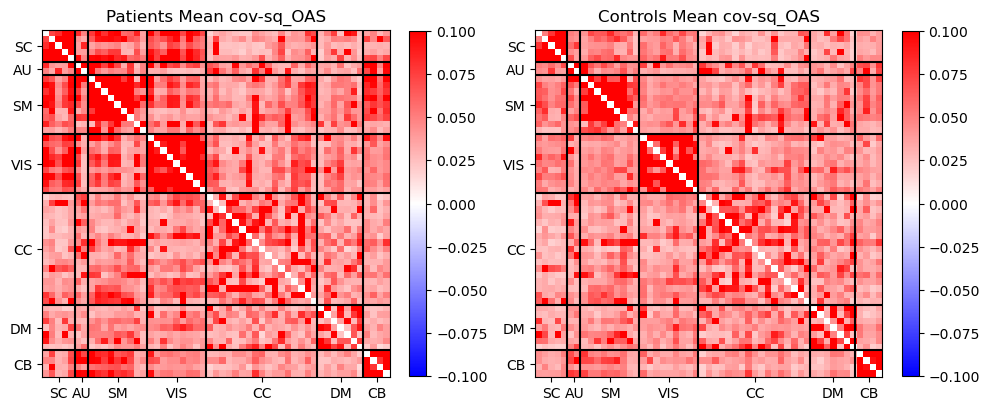

'cov-sq_ShrunkCovariance',


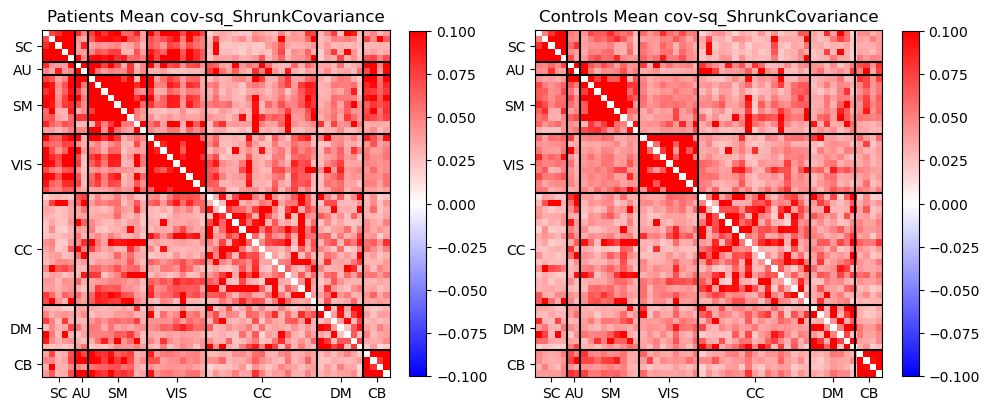

'prec_EmpiricalCovariance',


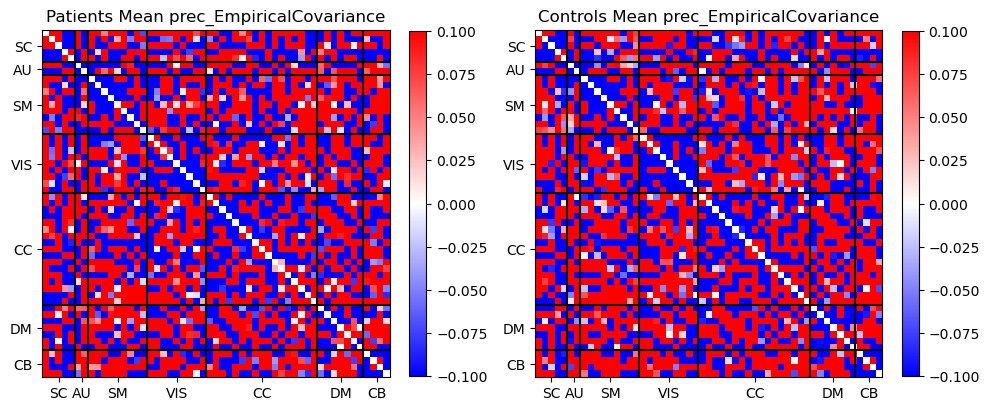

'prec_EllipticEnvelope',


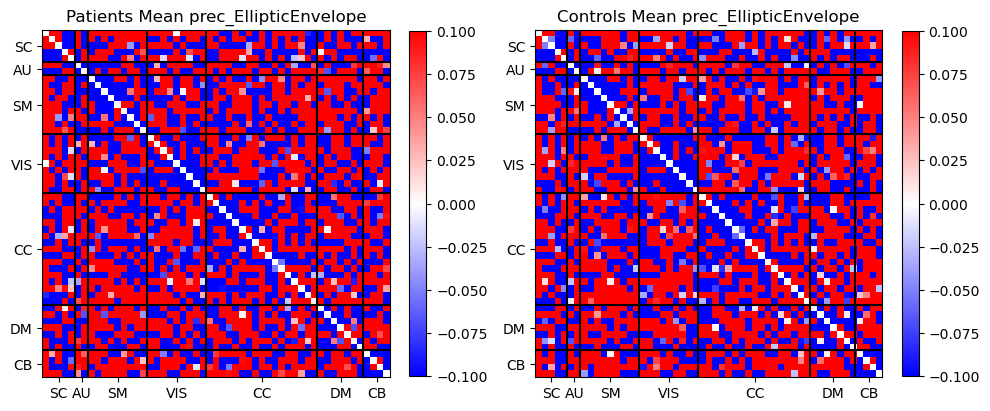

'prec_GraphicalLasso',


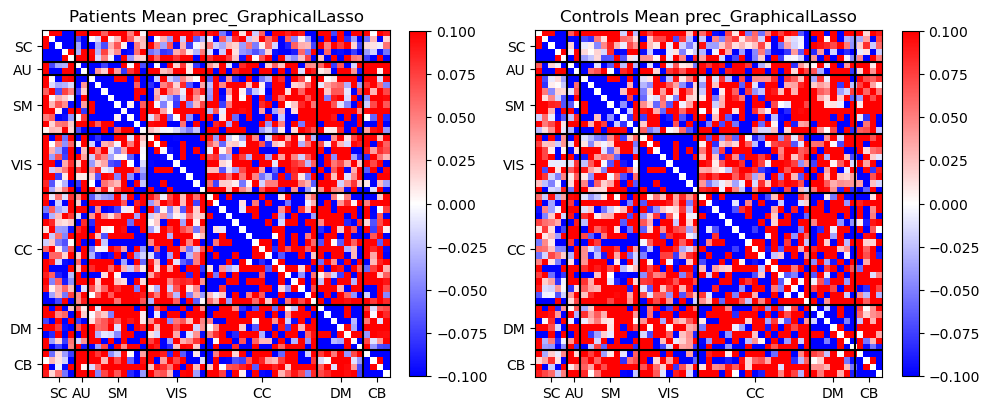

'prec_GraphicalLassoCV',


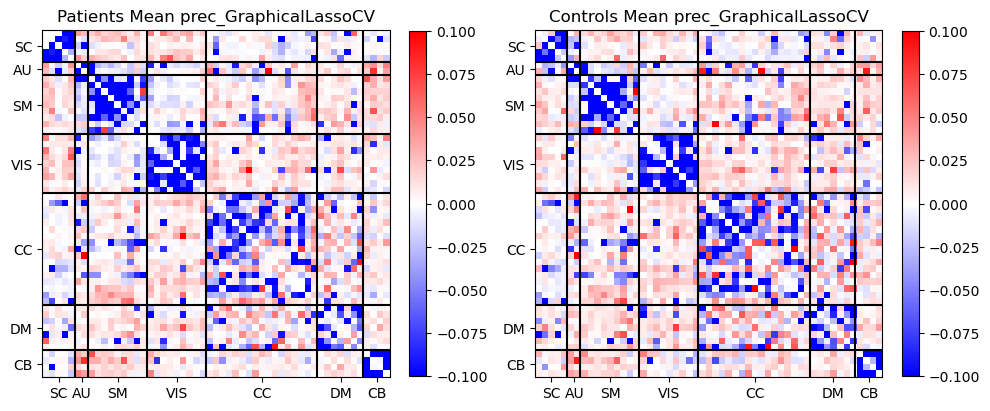

'prec_LedoitWolf',


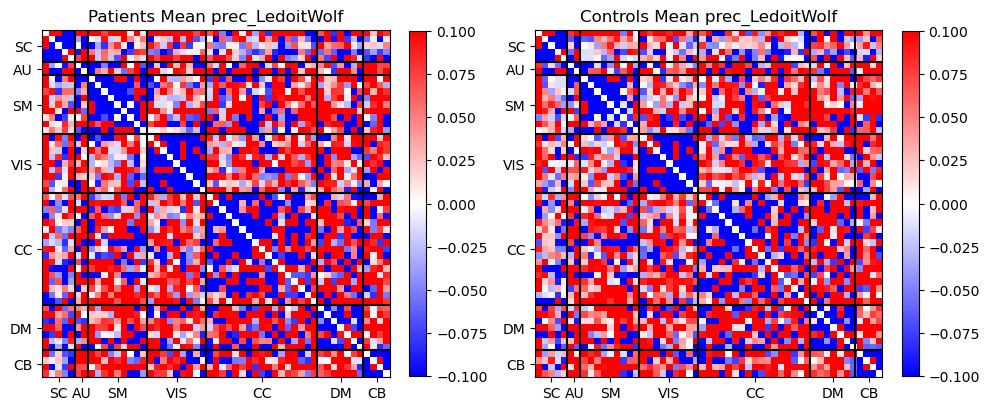

'prec_MinCovDet',


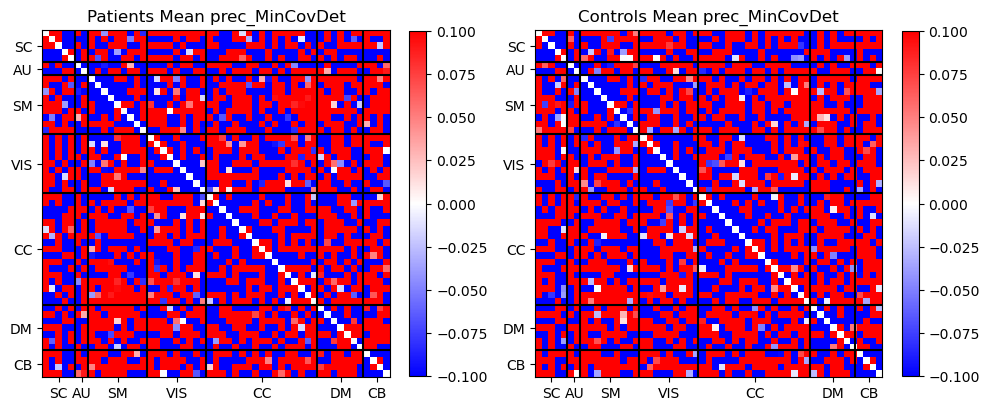

'prec_OAS',


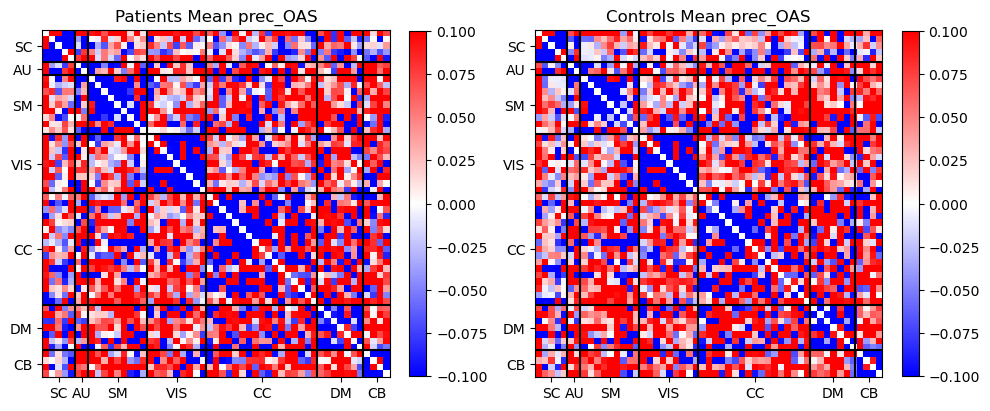

'prec_ShrunkCovariance',


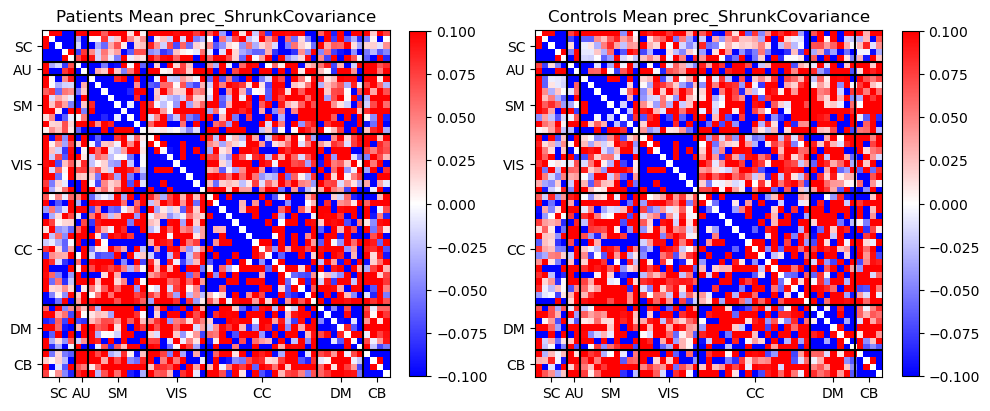

'spearmanr-sq',


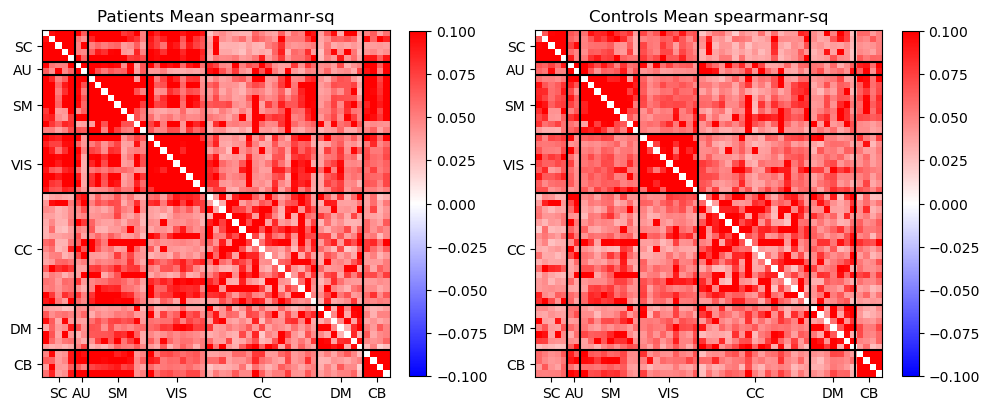

'spearmanr',


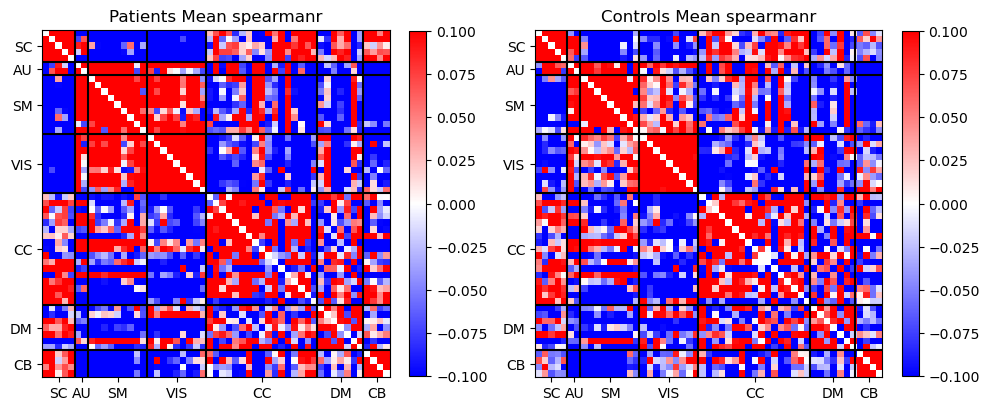

'kendalltau-sq',


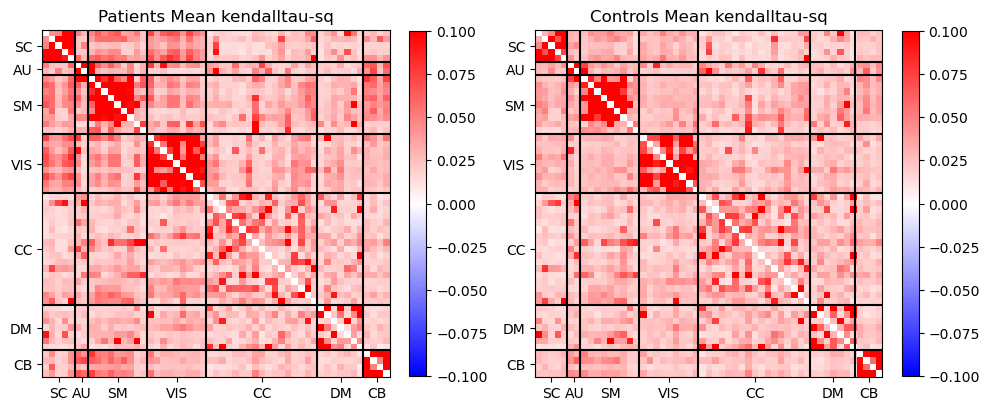

'kendalltau',


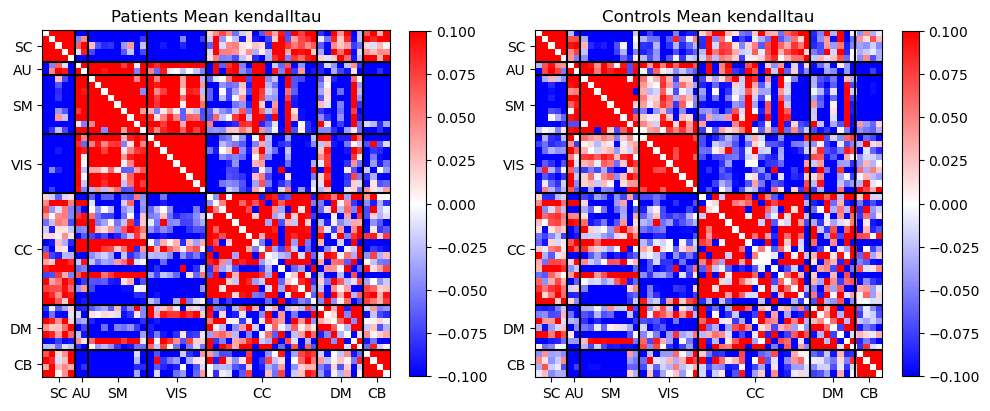

'xcorr_mean_sig-True',


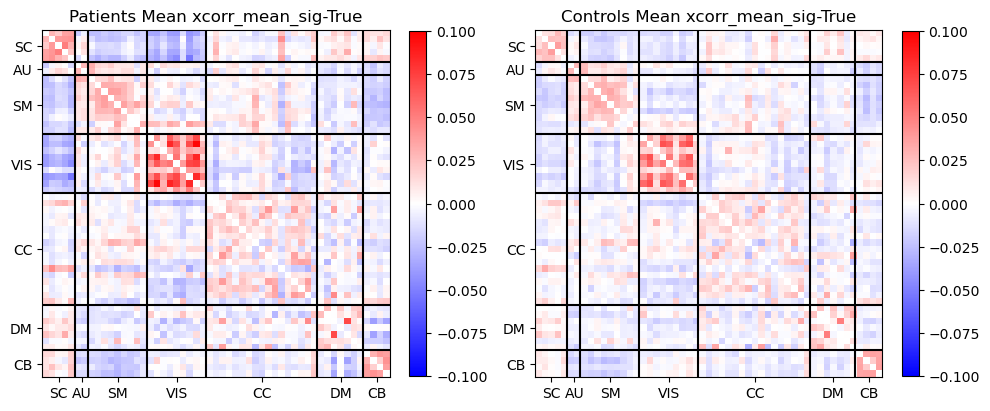

'xcorr-sq_mean_sig-True',


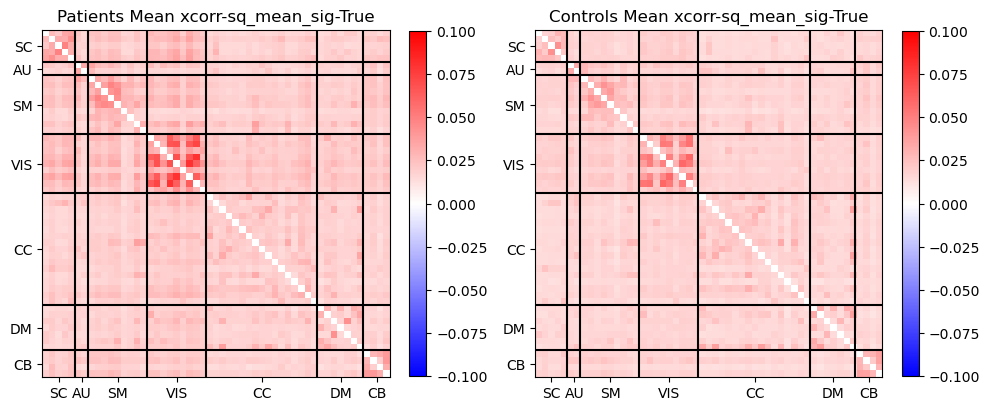

'xcorr-sq_mean_sig-False',


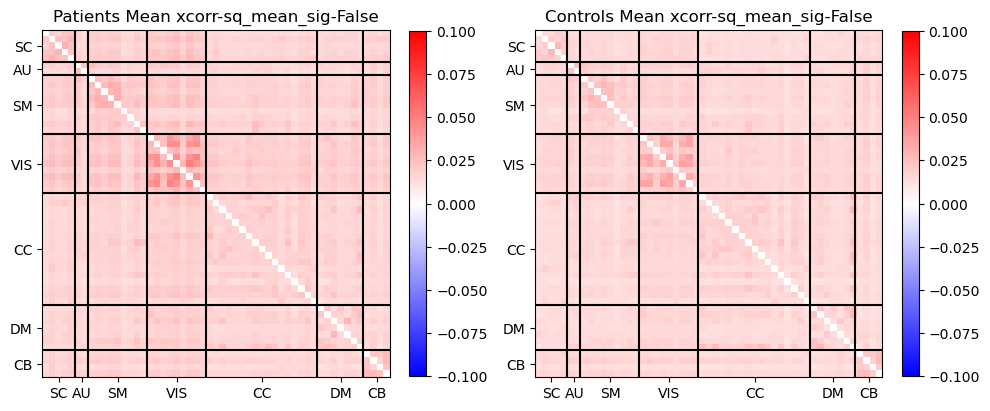

'dcorr',


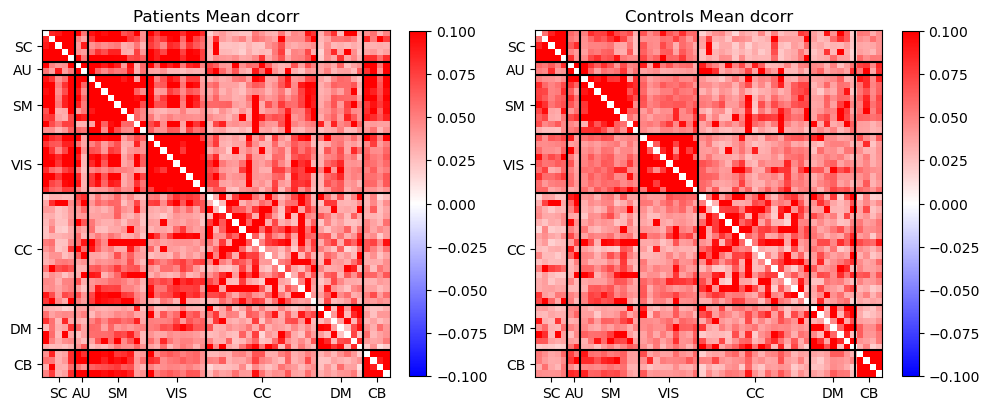

'mgc',


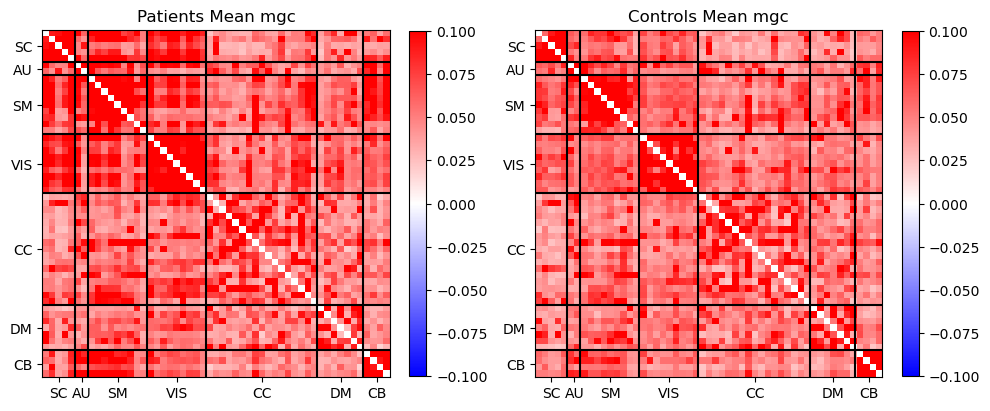

'hsic',


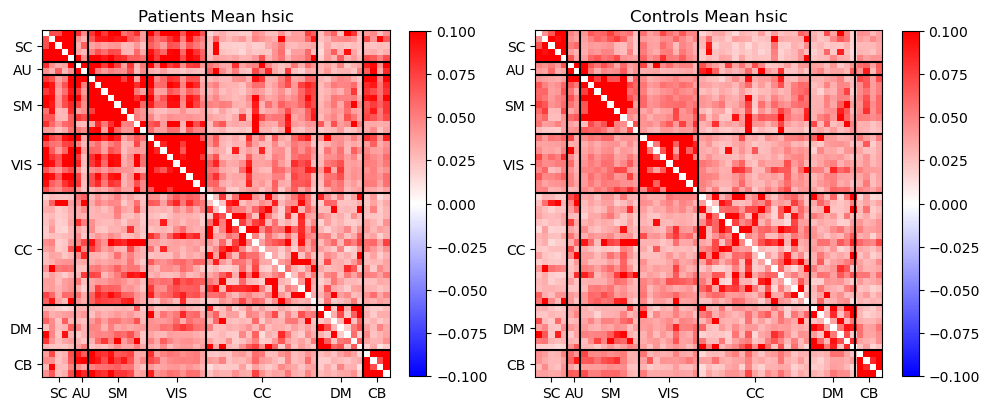

'dcorrx_maxlag-1',


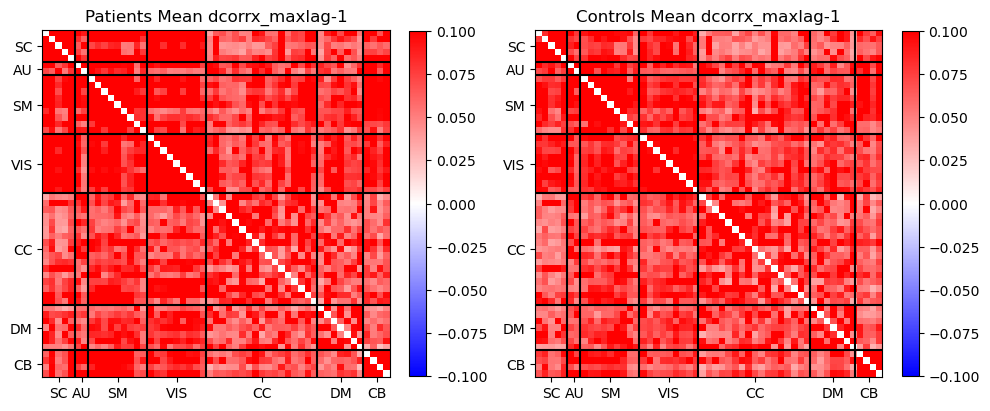

'pec',


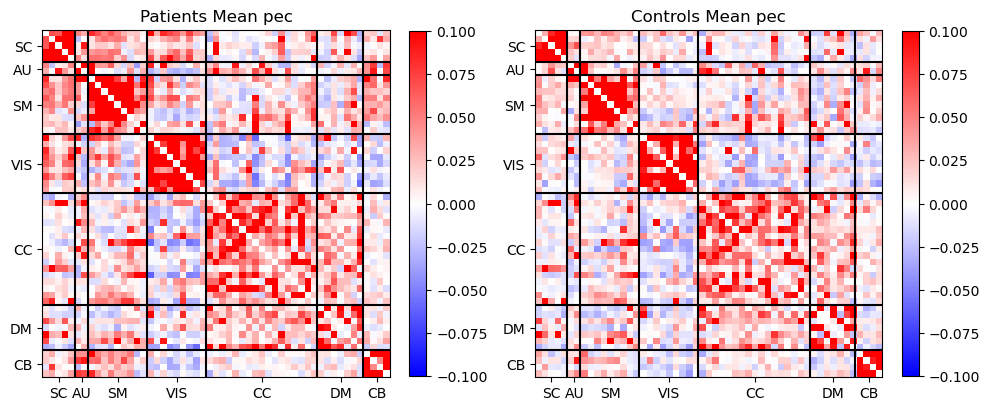

'pec_log',


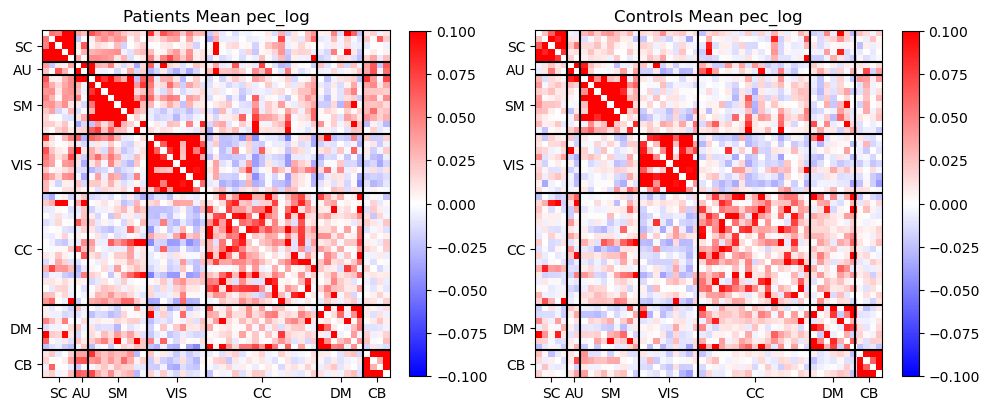

In [77]:
# manually inspect all SPIs

really_good_spis = [
    'cov_EmpiricalCovariance',
    'cov_EllipticEnvelope',
    'cov_GraphicalLasso',
    'cov_GraphicalLassoCV',
    'cov_LedoitWolf',
    'cov_MinCovDet',
    'cov_OAS',
    'cov_ShrunkCovariance',
    'cov-sq_EmpiricalCovariance',
    'cov-sq_EllipticEnvelope',
    'cov-sq_GraphicalLasso',
    'cov-sq_GraphicalLassoCV',
    'cov-sq_LedoitWolf',
    'cov-sq_MinCovDet',
    'cov-sq_OAS',
    'cov-sq_ShrunkCovariance',
    'prec_EmpiricalCovariance',
    'prec_EllipticEnvelope',
    'prec_GraphicalLasso',
    'prec_GraphicalLassoCV',
    'prec_LedoitWolf',
    'prec_MinCovDet',
    'prec_OAS',
    'prec_ShrunkCovariance',
    'spearmanr-sq',
    'spearmanr',
    'kendalltau-sq',
    'kendalltau',
    'xcorr_mean_sig-True',
    'xcorr-sq_mean_sig-True',
    'xcorr-sq_mean_sig-False',
    'dcorr',
    'mgc',
    'hsic',
    'dcorrx_maxlag-1',
    'pec',
    'pec_log',
]

bad_spis = [
    'xcorr_max_sig-True',
    'xcorr-sq_max_sig-True',
    'dcorr_biased',
    'hsic_biased',
    'dcorrx_maxlag-10',
    'gwtau',
    'cds',
    'psi_wavelet_max_fs-1_fmin-0_fmax-0-5_max',
    'psi_wavelet_max_fs-1_fmin-0-25_fmax-0-5_max',
    'xcorr_mean_sig-False',
    'reci',
    'igci',
    'pec_orth',
    'pec_orth_log',
    'pec_orth_abs',
    'pec_orth_log_abs'

]
bad_families = [
    'prec-sq',
    'pdist',
    'dtw',
    'softdtw',
    'lcss',
    'coint',
    'lmfit',
    'psi_wavelet',
]

for spi in ALL_DATA["spis"]:
    # if spi in really_good_spis:
    #     continue
    if spi in bad_spis:
        continue
    if any([spi.startswith(family) for family in bad_families]):
        continue

    print(f"'{spi}',")
    plot_means(ALL_DATA[spi], ALL_DATA["diags"], title=spi, unit_lim=False)

In [208]:
# filter data

DATA = {}
DATA["ts"] = ALL_DATA["ts"]
DATA["diags"] = ALL_DATA["diags"]
DATA["sexes"] = ALL_DATA["sexes"]
DATA["ages"] = ALL_DATA["ages"]
DATA["spis"] = really_good_spis
for spi in really_good_spis:
    DATA[spi] = ALL_DATA[spi]
with open(save_path+"good_data.pkl", 'wb') as f:
    dill.dump(DATA, f)

In [4]:
# load filtered data
import dill
with open(save_path+"good_data.pkl", 'rb') as f:
    DATA = dill.load(f) 

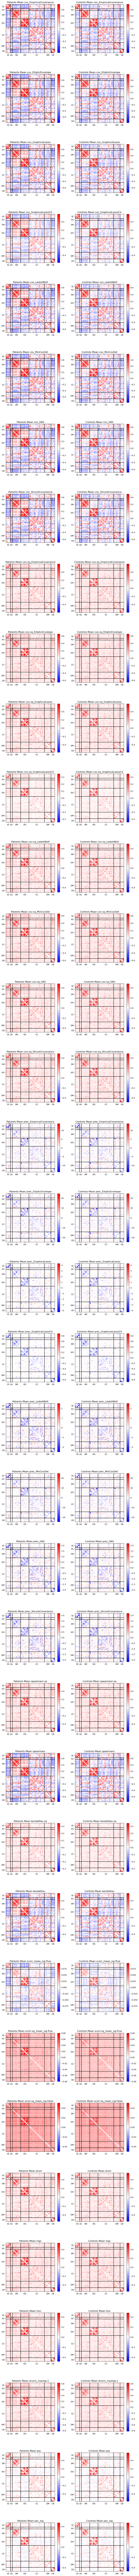

In [14]:
# plot all
diagnoses = DATA["diags"]
groups = np.unique(diagnoses)

fig, axes = plt.subplots(len(DATA["spis"]), 2, figsize=(10, 5*len(DATA["spis"])))
for i, spi in enumerate(DATA["spis"]):
    ax = axes[i]
    data = DATA[spi]

    # tril_indices = np.tril_indices_from(data[0])
    # vmin = np.nanmin(data[:, tril_indices[0], tril_indices[1]])
    # vmax = np.nanmax(data[:, tril_indices[0], tril_indices[1]])
    # vmax = max(abs(vmin), abs(vmax))
    # vmin = -vmax

    group_data = [data[diagnoses == g] for g in groups]
    means = [np.mean(gd, axis=0) for gd in group_data]
    
    tril_indices = np.tril_indices_from(data[0])
    vmin = np.nanmin(means[0][tril_indices[0], tril_indices[1]])
    vmax = np.nanmax(means[0][tril_indices[0], tril_indices[1]])
    vmax = max(abs(vmin), abs(vmax))
    vmin = -vmax

    # print(F"Plotting SPI: {spi}, vmin: {vmin}, vmax: {vmax}")

    cax = plot_heatmap(means[0], ax[0], cmap='bwr', vmin=vmin, vmax=vmax)
    fig.colorbar(cax, ax=ax[0], fraction=0.045)
    ax[0].set_title(f"Patients Mean {spi}")
    cax = plot_heatmap(means[1], ax[1], cmap='bwr', vmin=vmin, vmax=vmax)
    fig.colorbar(cax, ax=ax[1], fraction=0.045)
    ax[1].set_title(f"Controls Mean {spi}")
    
plt.tight_layout()
plt.show()

In [64]:
# derive stats for all SPIs and save

def compute_stats(data_dict):
    stats = {}

    for spi in data_dict["spis"]:
        print(f"Analyzing SPI: {spi}")
        data = data_dict[spi]
        stat, p_value, p_thresh = analyze_group_differences(data, data_dict["diags"], fdr=True, p_threshold=0.05)
        stats[spi] = {
            "stat": stat,
            "p_value": p_value,
            "p_thresh": p_thresh
        }
        r_significant = np.sum(p_thresh)/np.size(p_thresh)

        importances, importance_mask = forest_features(data, data_dict["diags"], threshold=r_significant)
        stats[spi]["importances"] = importances
        stats[spi]["importance_mask"] = importance_mask
        stats[spi]["r_significant"] = r_significant

    proc_stats = {}

    families = ["cov_", "cov-sq_", "prec_"]
    for spi_family in families:
        
        target_data = []
        for spi in data_dict["spis"]:
            if spi.startswith(spi_family):
                target_data.append(stats[spi])

        new_spi = {}
        new_spi["p_thresh"] = np.mean([d["p_thresh"].astype(int) for d in target_data], axis=0)
        new_spi["importance_mask"] = np.mean([d["importance_mask"].astype(int) for d in target_data], axis=0)
        proc_stats[f"{spi_family[:-1]}"] = new_spi

    for spi in data_dict["spis"]:
        # print(spi)
        if not any([spi.startswith(family) for family in families]):
            proc_stats[spi] = {
                "p_thresh": stats[spi]["p_thresh"],
                "importance_mask": stats[spi]["importance_mask"]
            }
    
    return stats, proc_stats

STATS, PROC_STATS = compute_stats(DATA)
import dill
with open(save_path+"stats.pkl", 'wb') as f:
    dill.dump(STATS, f)
with open(save_path+"proc_stats.pkl", 'wb') as f:
    dill.dump(PROC_STATS, f)

Analyzing SPI: cov_EmpiricalCovariance


KeyboardInterrupt: 

In [5]:
# load the data
import dill
with open(save_path+"stats.pkl", 'rb') as f:
    STATS = dill.load(f)
with open(save_path+"proc_stats.pkl", 'rb') as f:
    PROC_STATS = dill.load(f)

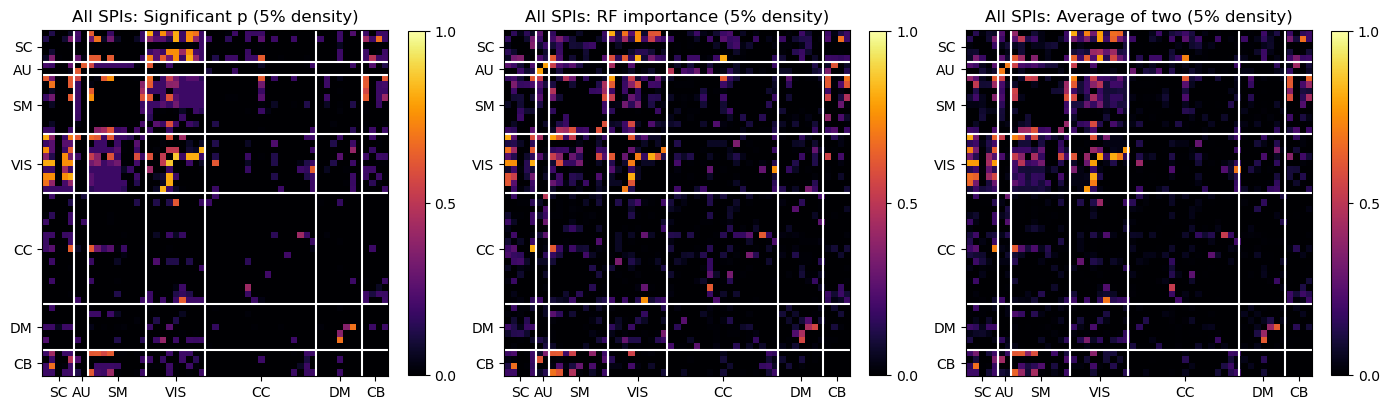

In [11]:
p_threshs, importance_masks = [], []
for spi in PROC_STATS:
    p_threshs.append(PROC_STATS[spi]["p_thresh"].astype(float))
    importance_masks.append(PROC_STATS[spi]["importance_mask"].astype(float))

p_thresh = np.mean(np.array(p_threshs), axis=0)
importance_mask = np.mean(np.array(importance_masks), axis=0)
plot_and_matrix(p_thresh, importance_mask, aggregated=True, title="All SPIs")

# for spi in PROC_STATS:
#     print(f"Analyzing SPI: {spi}")
#     p_thresh = PROC_STATS[spi]["p_thresh"]
#     importance_mask = PROC_STATS[spi]["importance_mask"]
    
#     # plot_stats(stat, p_value, p_thresh, title=spi)
#     # plot_importances(importances, importance_mask)
#     if spi in [family[:-1] for family in families]:
#         plot_and_matrix(p_thresh, importance_mask, aggregated=True)
#     else:
#         plot_and_matrix(p_thresh, importance_mask)
#     # break

Analyzing SPI: cov


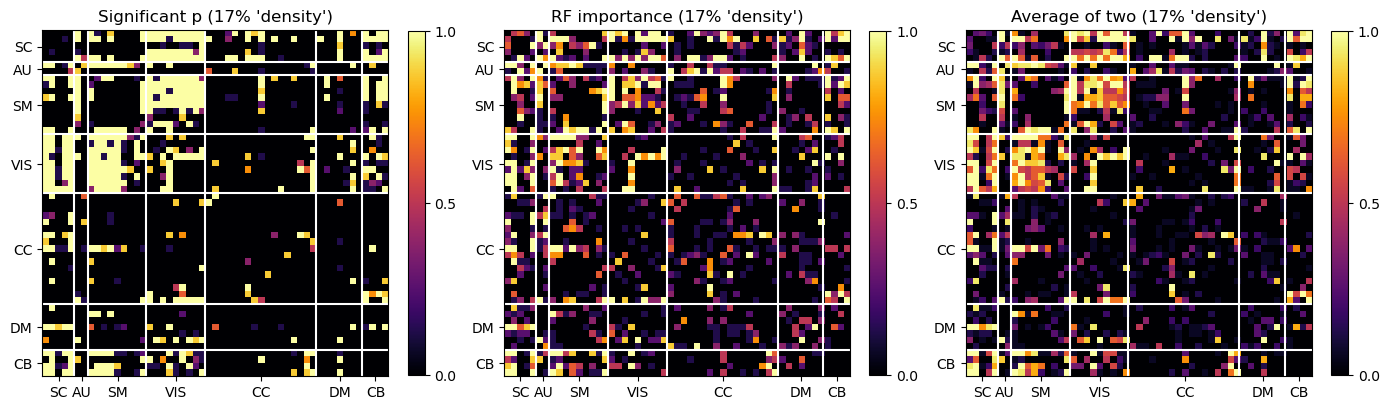

Analyzing SPI: cov-sq


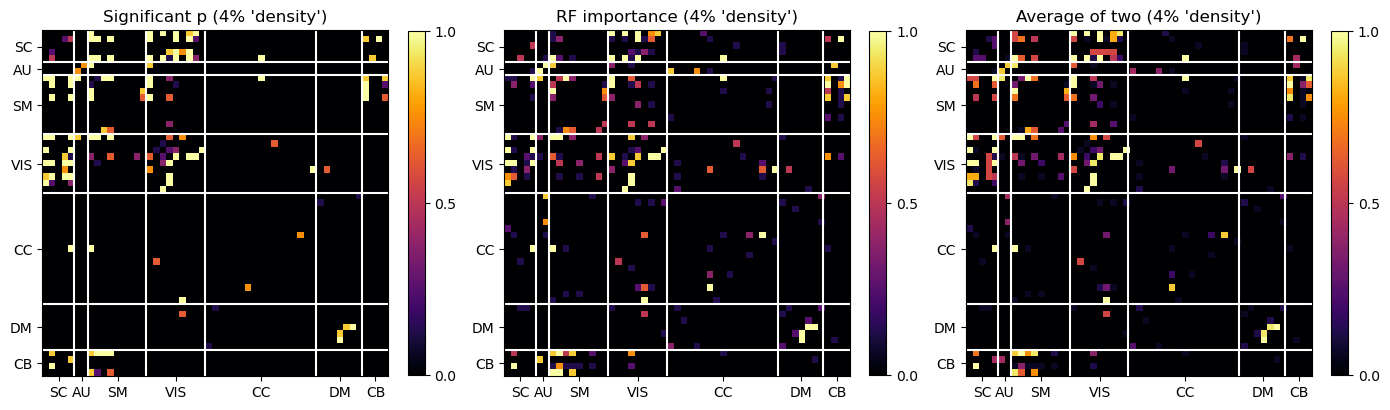

Analyzing SPI: prec


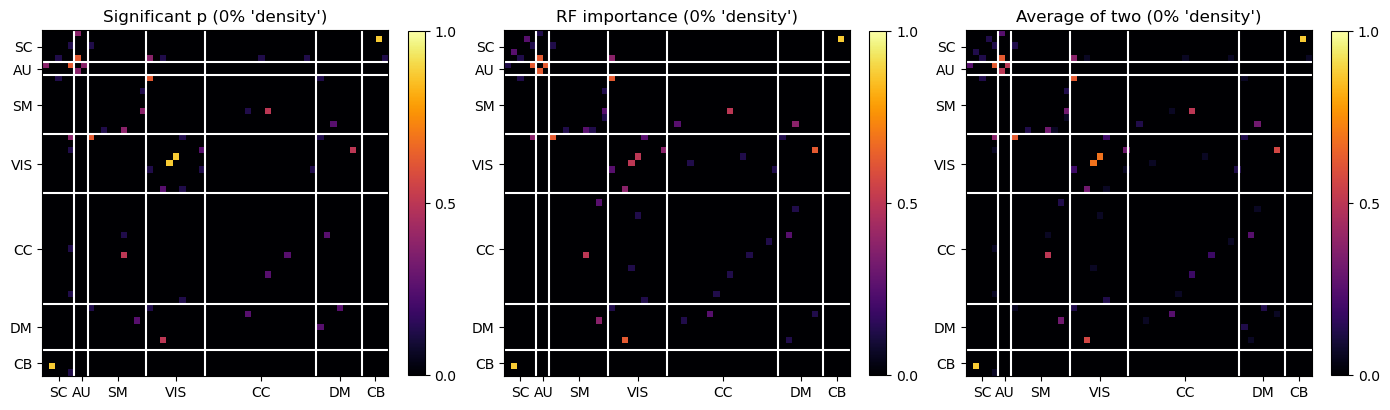

Analyzing SPI: spearmanr-sq


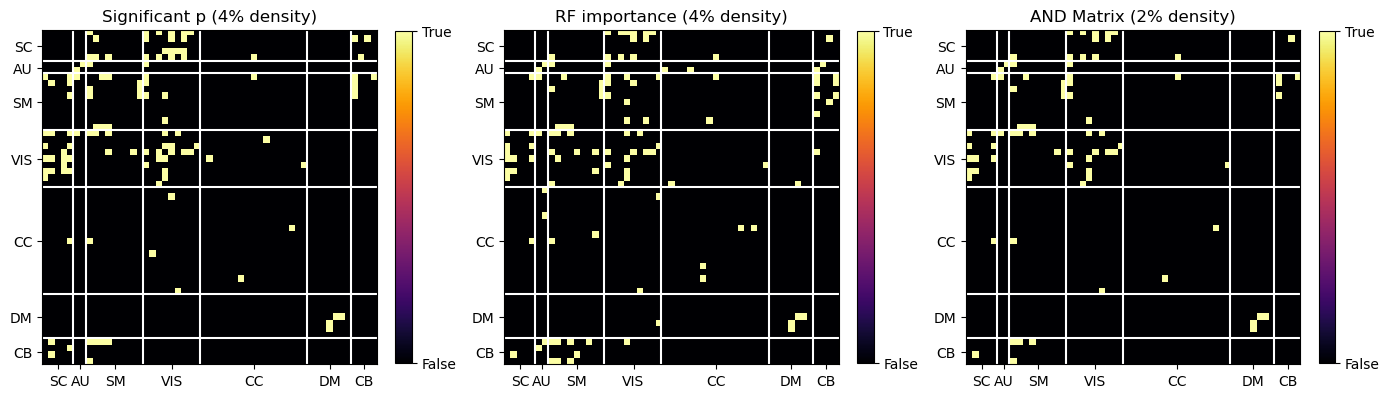

Analyzing SPI: spearmanr


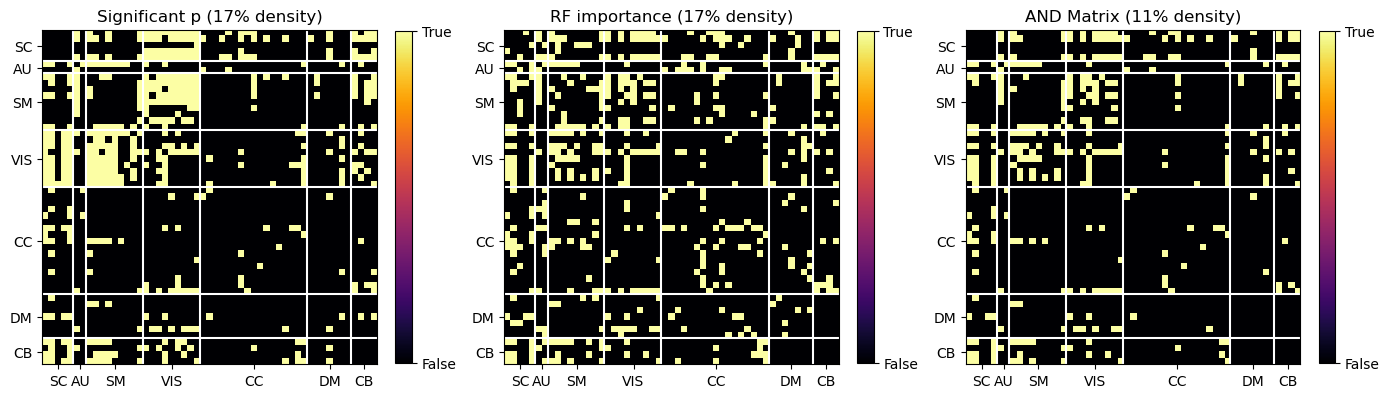

Analyzing SPI: kendalltau-sq


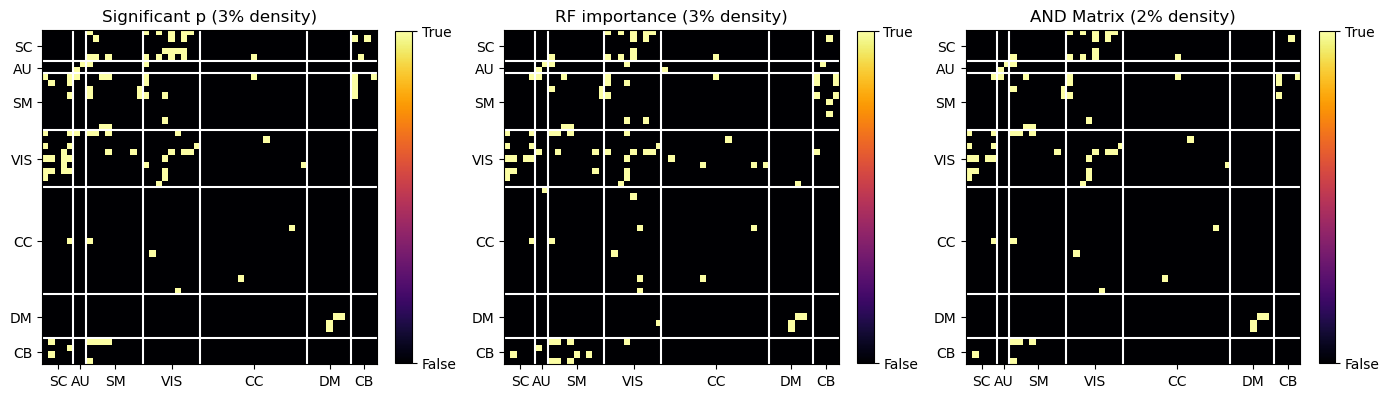

Analyzing SPI: kendalltau


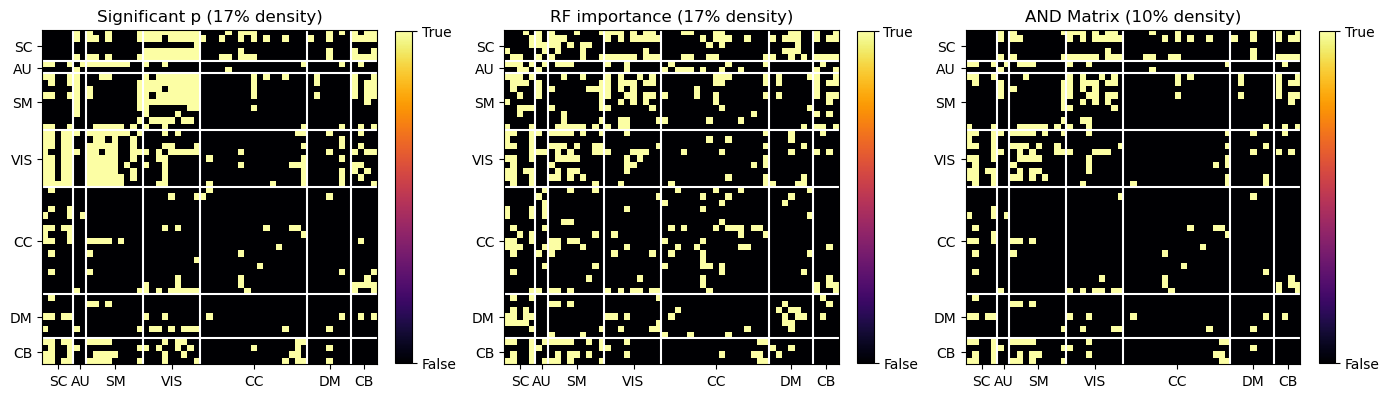

Analyzing SPI: xcorr_mean_sig-True


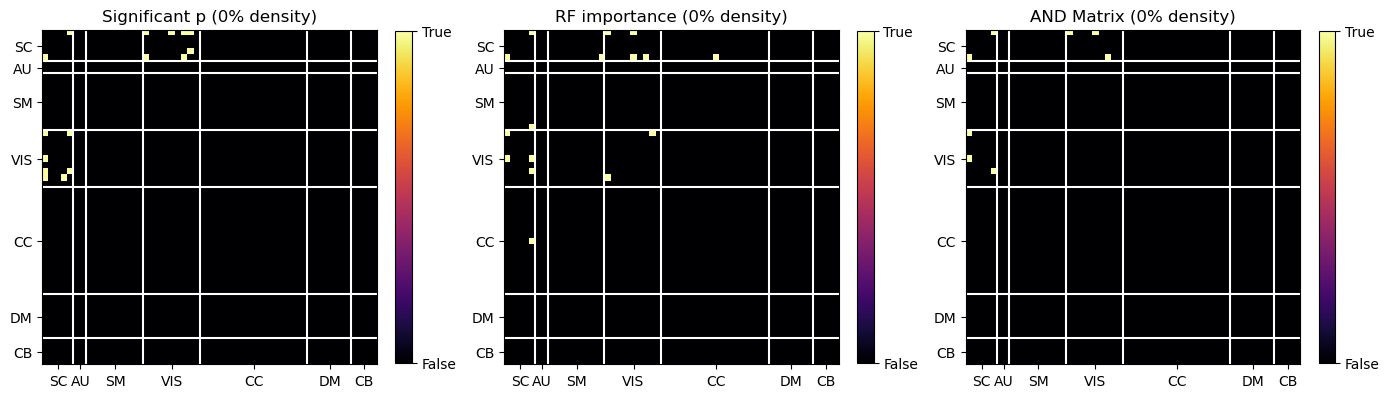

Analyzing SPI: xcorr-sq_mean_sig-True


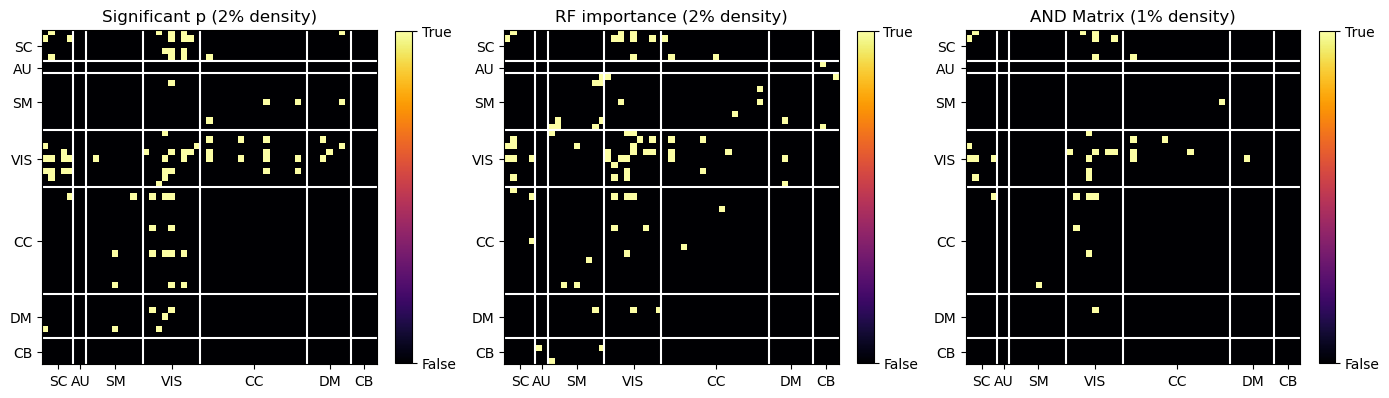

Analyzing SPI: xcorr-sq_mean_sig-False


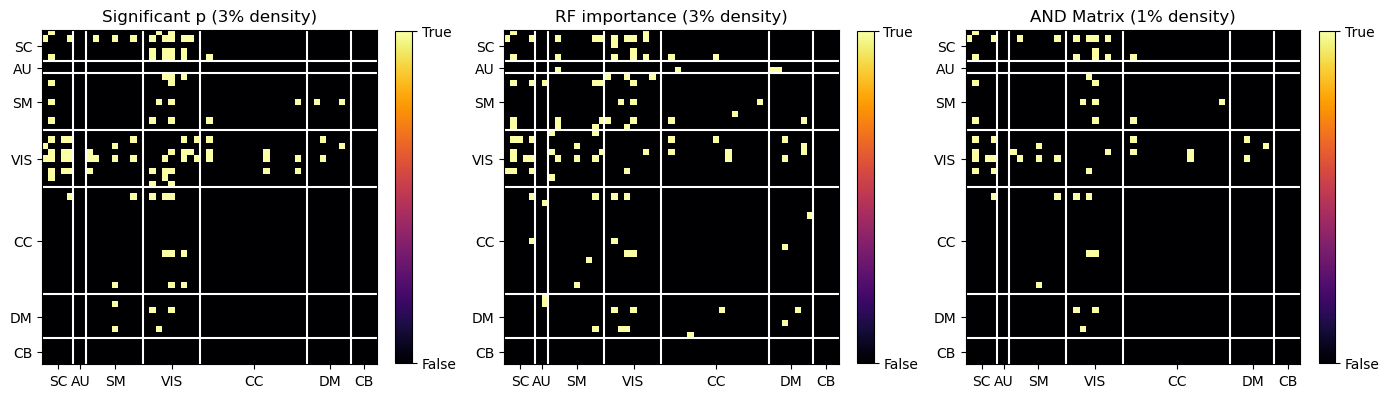

Analyzing SPI: dcorr


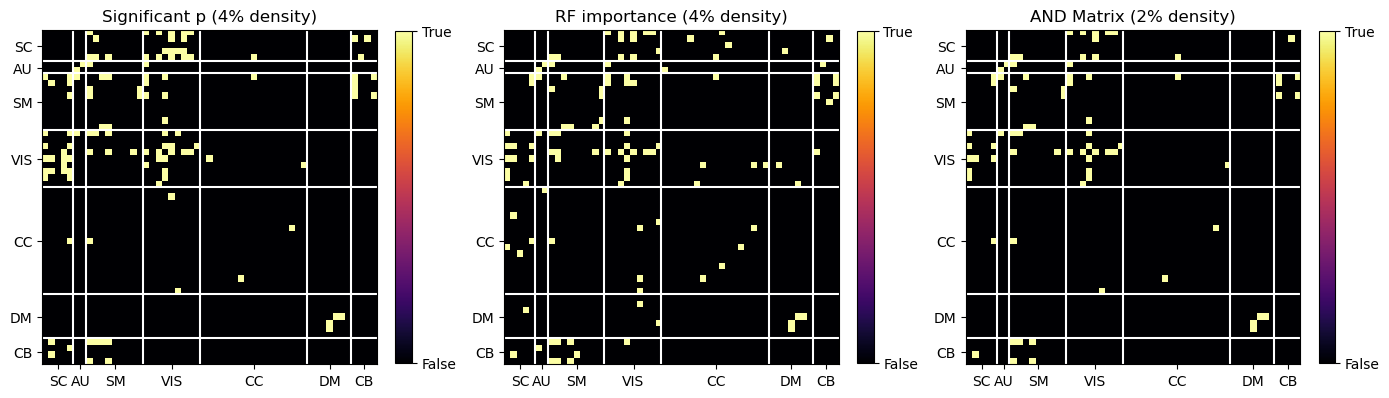

Analyzing SPI: mgc


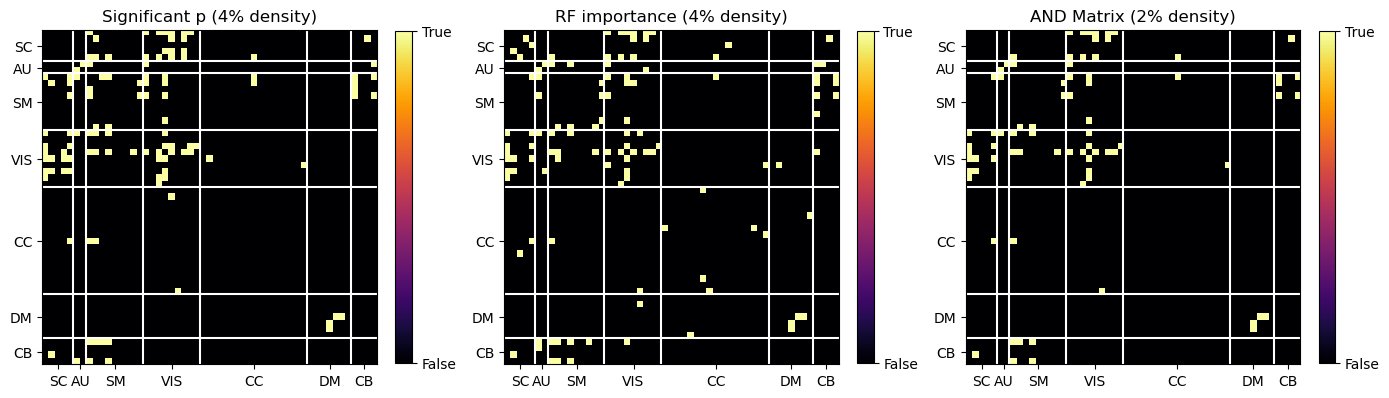

Analyzing SPI: hsic


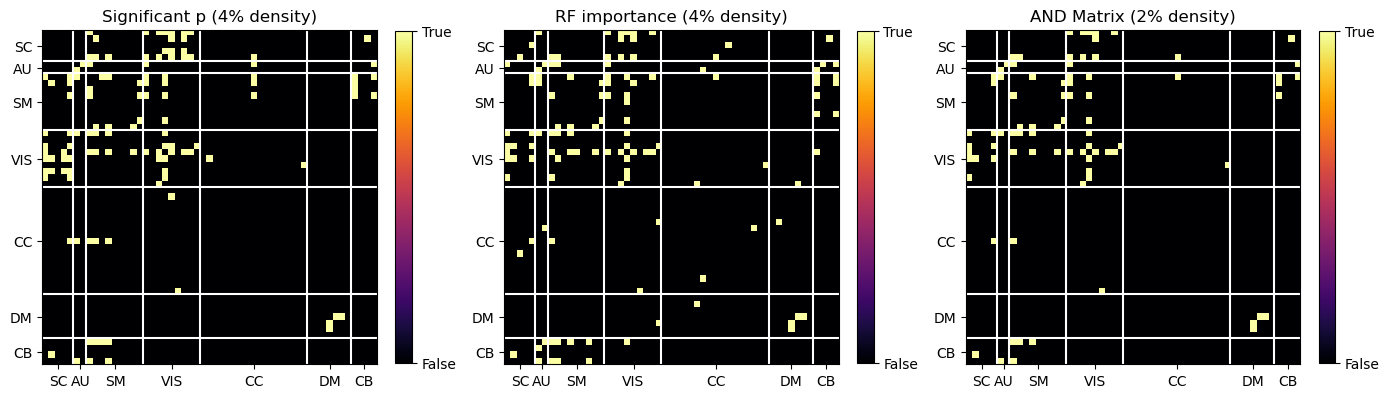

Analyzing SPI: dcorrx_maxlag-1


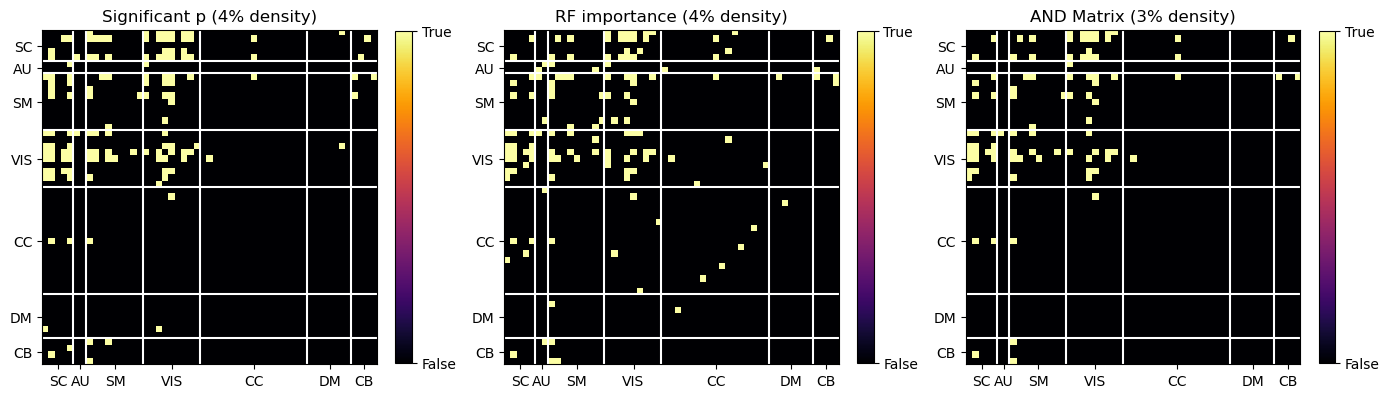

Analyzing SPI: pec


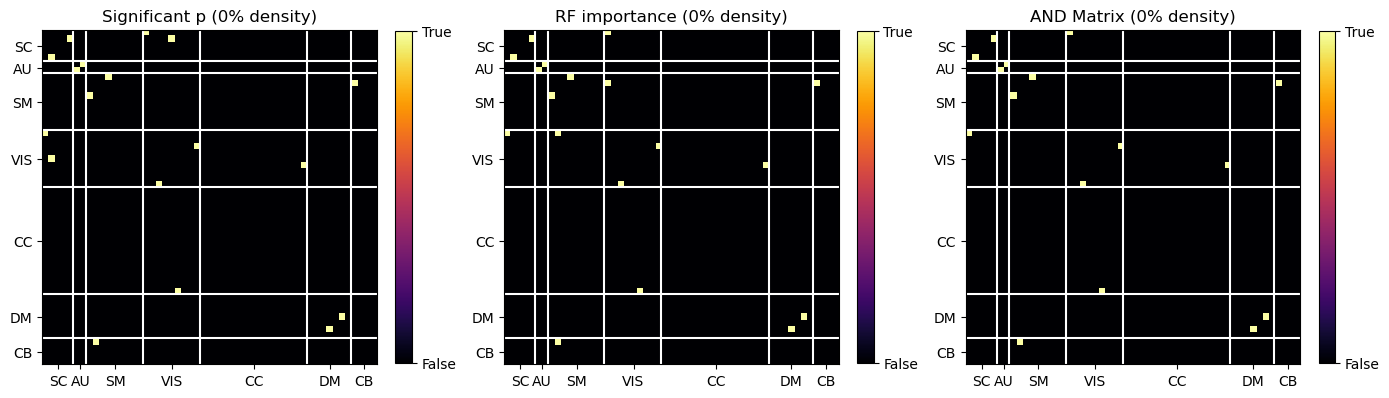

Analyzing SPI: pec_log


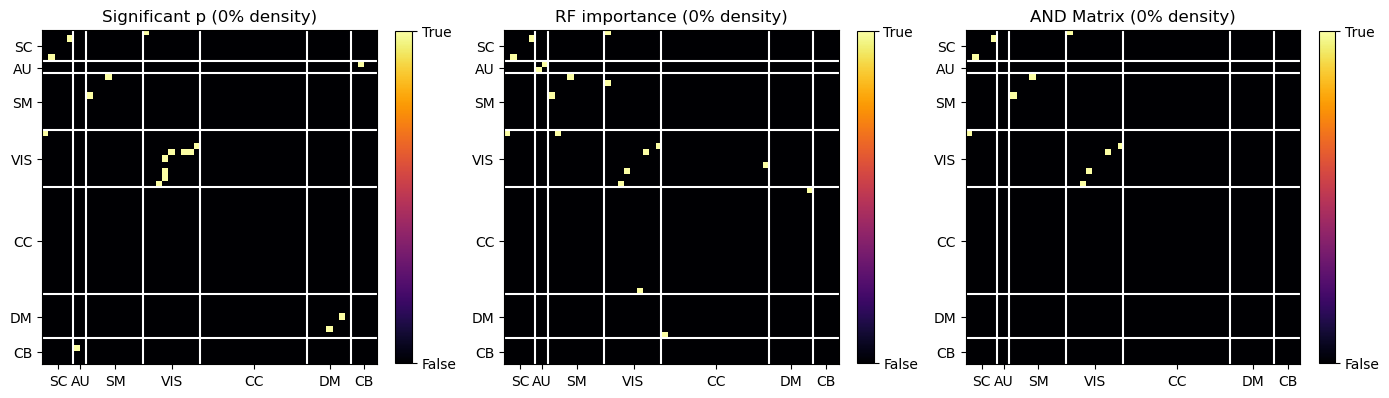

In [78]:
for spi in PROC_STATS:
    print(f"Analyzing SPI: {spi}")
    p_thresh = PROC_STATS[spi]["p_thresh"]
    importance_mask = PROC_STATS[spi]["importance_mask"]
    
    # plot_stats(stat, p_value, p_thresh, title=spi)
    # plot_importances(importances, importance_mask)
    if spi in [family[:-1] for family in families]:
        plot_and_matrix(p_thresh, importance_mask, aggregated=True)
    else:
        plot_and_matrix(p_thresh, importance_mask)
    # break

Analyzing SPI: kendalltau


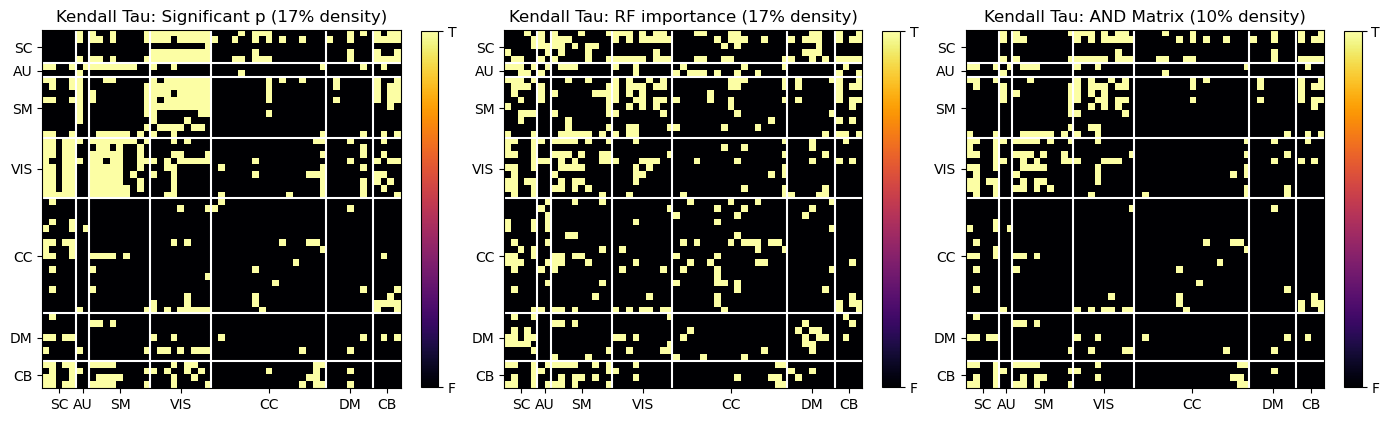

In [22]:
spi = "kendalltau"
print(f"Analyzing SPI: {spi}")
p_thresh = PROC_STATS[spi]["p_thresh"]
importance_mask = PROC_STATS[spi]["importance_mask"]
plot_and_matrix(p_thresh, importance_mask, title="Kendall Tau")



Analyzing SPI: dcorr


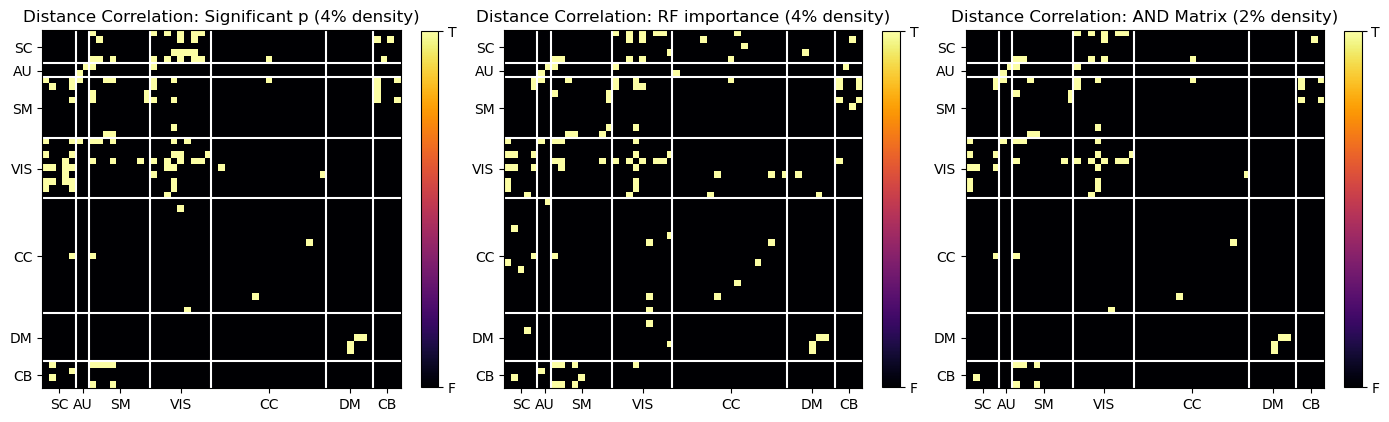

In [23]:
spi = "dcorr"
print(f"Analyzing SPI: {spi}")
p_thresh = PROC_STATS[spi]["p_thresh"]
importance_mask = PROC_STATS[spi]["importance_mask"]
plot_and_matrix(p_thresh, importance_mask, title="Distance Correlation")

## Permutations

In [65]:
import dill
perm_path = "/Users/ppopov1/adm-proj/data/permutations/"

def permute_data(data_dict):
    permuted_data = {}
    n_samples = data_dict["ts"].shape[0]
    random_indices = np.random.permutation(n_samples)[:n_samples//3*2]
    for key in data_dict:
        if key not in ["spis"]:
            permuted_data[key] = data_dict[key][random_indices]
    permuted_data["spis"] = data_dict["spis"]

    return permuted_data

proc_stats = []

for i in range(10,20):
    print(f"Permutation {i+1}/70")
    perm_data = permute_data(DATA)
    perm_stats, perm_proc_stats = compute_stats(perm_data)
    proc_stats.append(perm_proc_stats)
    with open(perm_path+f"perm_proc_stats_{i}.pkl", 'wb') as f:
        dill.dump(perm_proc_stats, f)

Permutation 11/70
Analyzing SPI: cov_EmpiricalCovariance
Analyzing SPI: cov_EllipticEnvelope
Analyzing SPI: cov_GraphicalLasso
Analyzing SPI: cov_GraphicalLassoCV
Analyzing SPI: cov_LedoitWolf
Analyzing SPI: cov_MinCovDet
Analyzing SPI: cov_OAS
Analyzing SPI: cov_ShrunkCovariance
Analyzing SPI: cov-sq_EmpiricalCovariance
Analyzing SPI: cov-sq_EllipticEnvelope
Analyzing SPI: cov-sq_GraphicalLasso
Analyzing SPI: cov-sq_GraphicalLassoCV
Analyzing SPI: cov-sq_LedoitWolf
Analyzing SPI: cov-sq_MinCovDet
Analyzing SPI: cov-sq_OAS
Analyzing SPI: cov-sq_ShrunkCovariance
Analyzing SPI: prec_EmpiricalCovariance
Analyzing SPI: prec_EllipticEnvelope
Analyzing SPI: prec_GraphicalLasso
Analyzing SPI: prec_GraphicalLassoCV
Analyzing SPI: prec_LedoitWolf
Analyzing SPI: prec_MinCovDet
Analyzing SPI: prec_OAS
Analyzing SPI: prec_ShrunkCovariance
Analyzing SPI: spearmanr-sq
Analyzing SPI: spearmanr
Analyzing SPI: kendalltau-sq
Analyzing SPI: kendalltau
Analyzing SPI: xcorr_mean_sig-True
Analyzing SPI: xco

In [19]:
proc_stats = []
perm_path = "/Users/ppopov1/adm-proj/data/permutations/"
for i in range(20):
    with open(perm_path+f"perm_proc_stats_{i}.pkl", 'rb') as f:
        proc_stats.append(dill.load(f))
len(proc_stats)

20

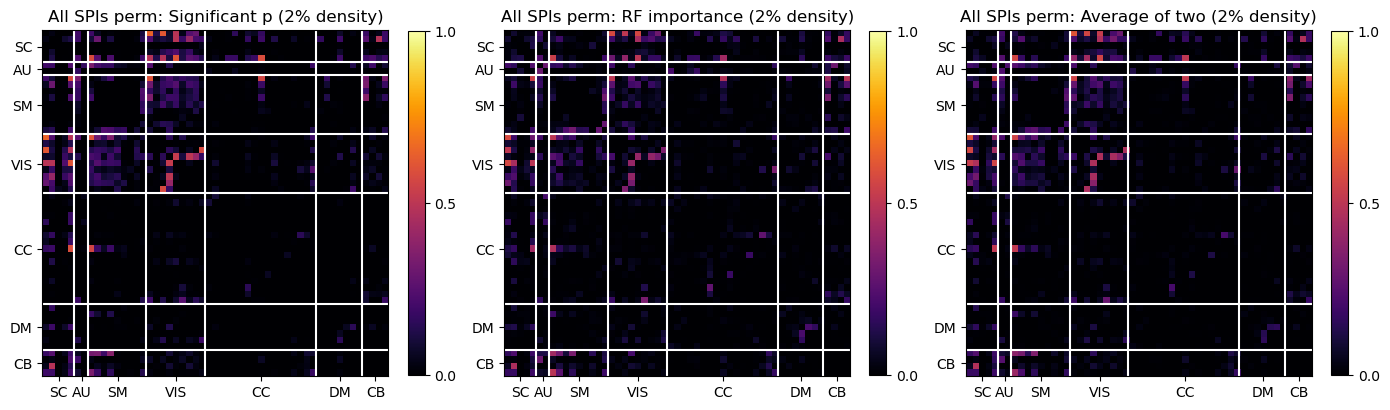

In [20]:
stat_agg, tree_agg = [], []
for stat in proc_stats:
    p_threshs, importance_masks = [], []
    for spi in stat:
        p_threshs.append(stat[spi]["p_thresh"].astype(float))
        importance_masks.append(stat[spi]["importance_mask"].astype(float))

    p_thresh = np.mean(np.array(p_threshs), axis=0)
    importance_mask = np.mean(np.array(importance_masks), axis=0)

    stat_agg.append(p_thresh)
    tree_agg.append(importance_mask)

p_thresh = np.mean(np.array(stat_agg), axis=0)
importance_mask = np.mean(np.array(tree_agg), axis=0)
plot_and_matrix(p_thresh, importance_mask, aggregated=True, title="All SPIs perm")

# Dump

Analyzing SPI: cov_EmpiricalCovariance


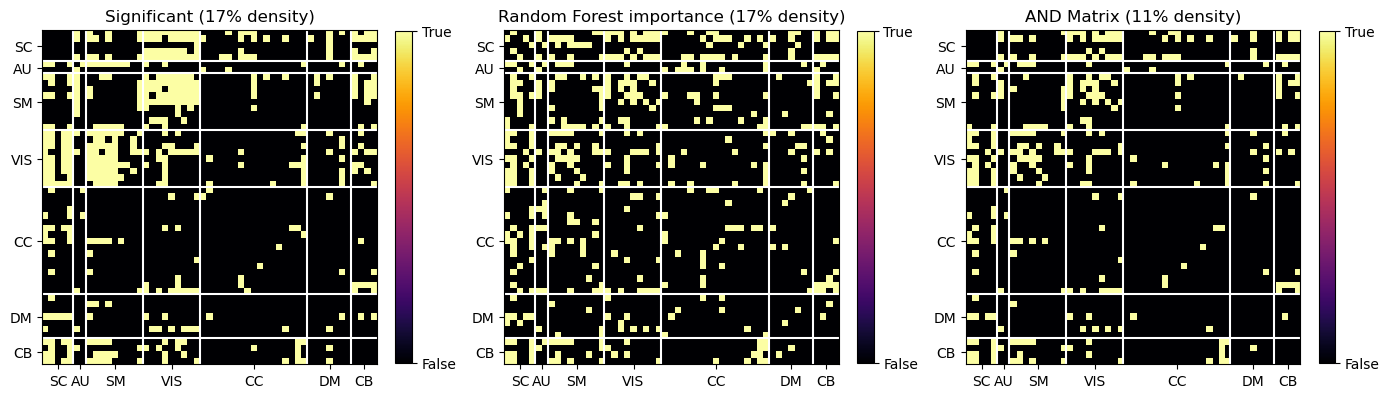

Analyzing SPI: cov_EllipticEnvelope


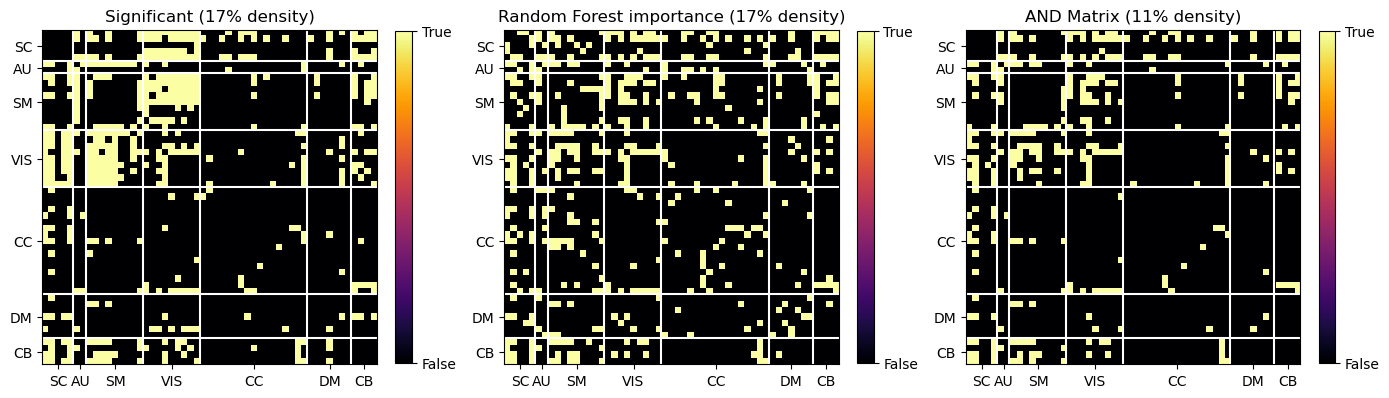

Analyzing SPI: cov_GraphicalLasso


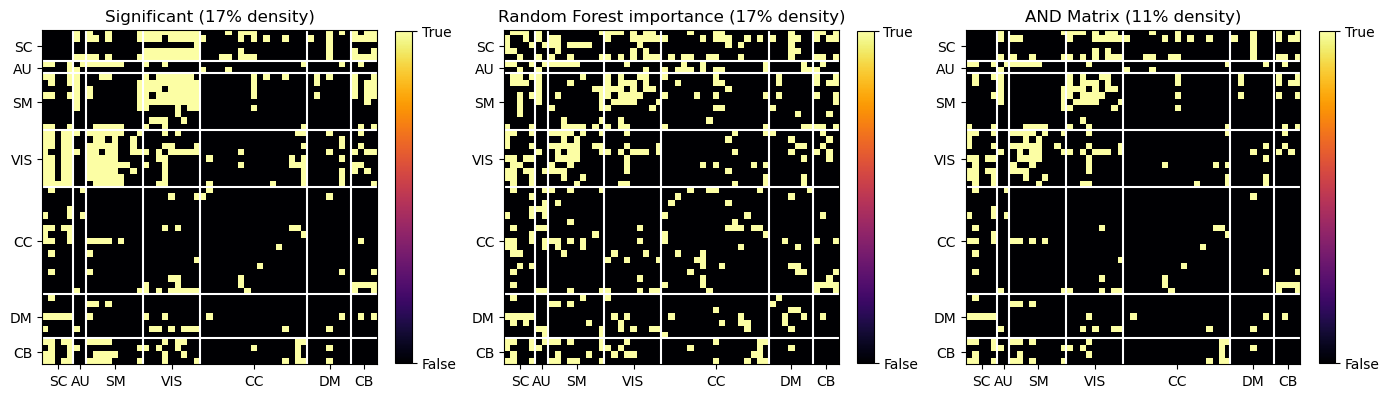

Analyzing SPI: cov_GraphicalLassoCV


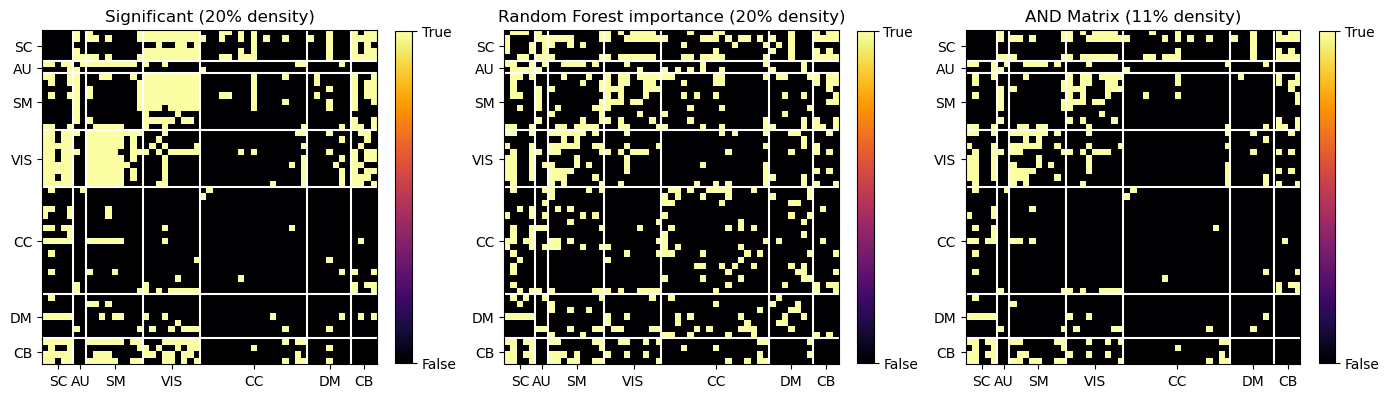

Analyzing SPI: cov_LedoitWolf


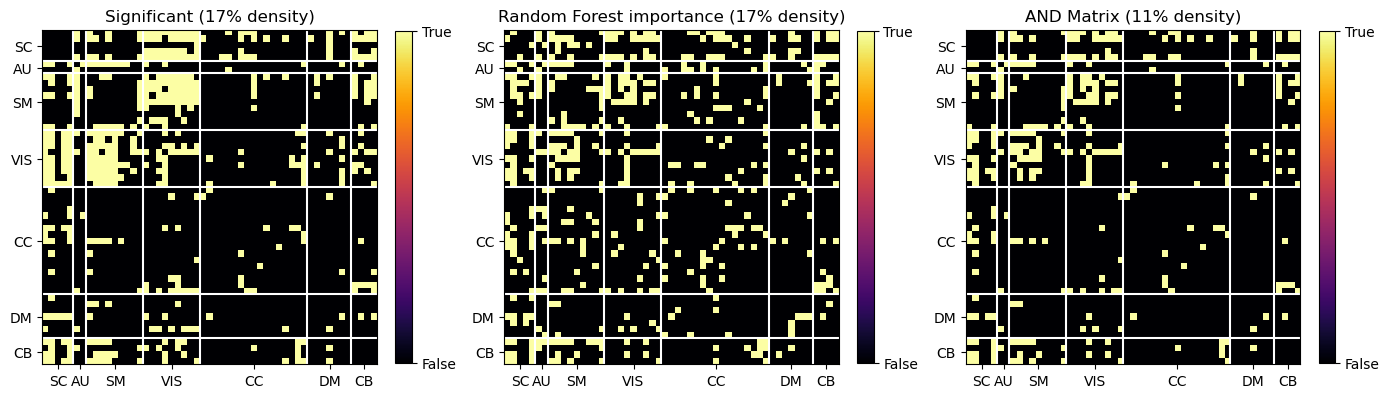

Analyzing SPI: cov_MinCovDet


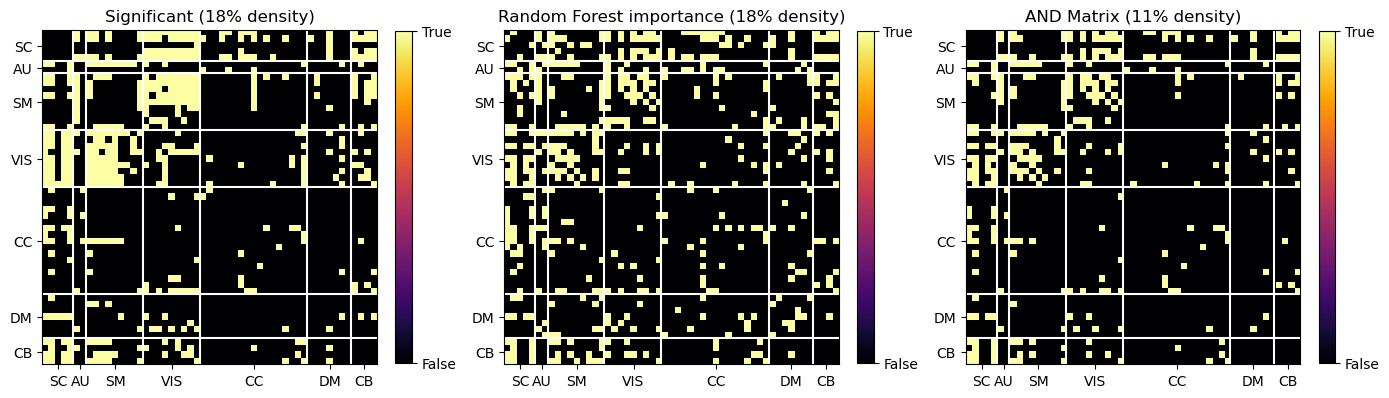

Analyzing SPI: cov_OAS


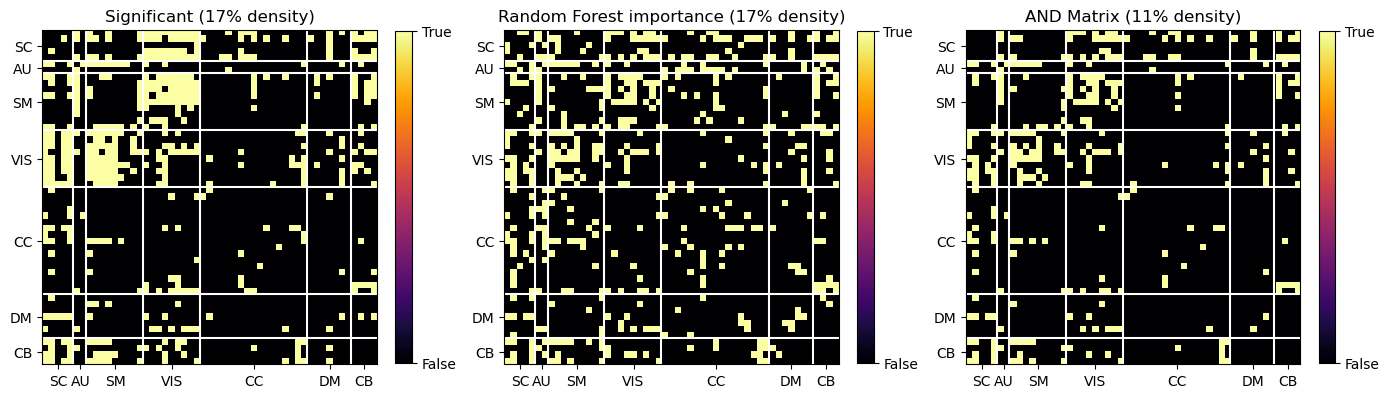

Analyzing SPI: cov_ShrunkCovariance


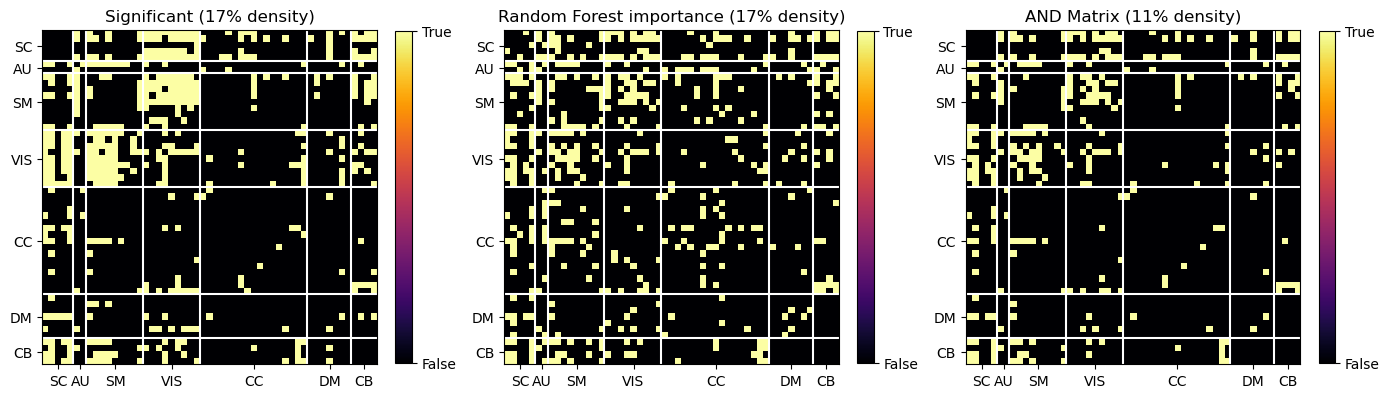

Analyzing SPI: cov-sq_EmpiricalCovariance


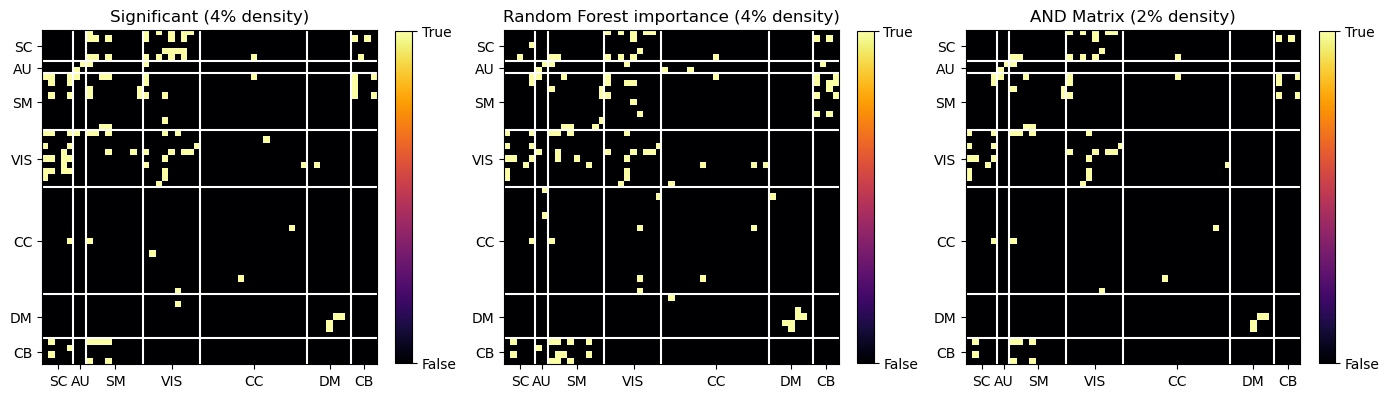

Analyzing SPI: cov-sq_EllipticEnvelope


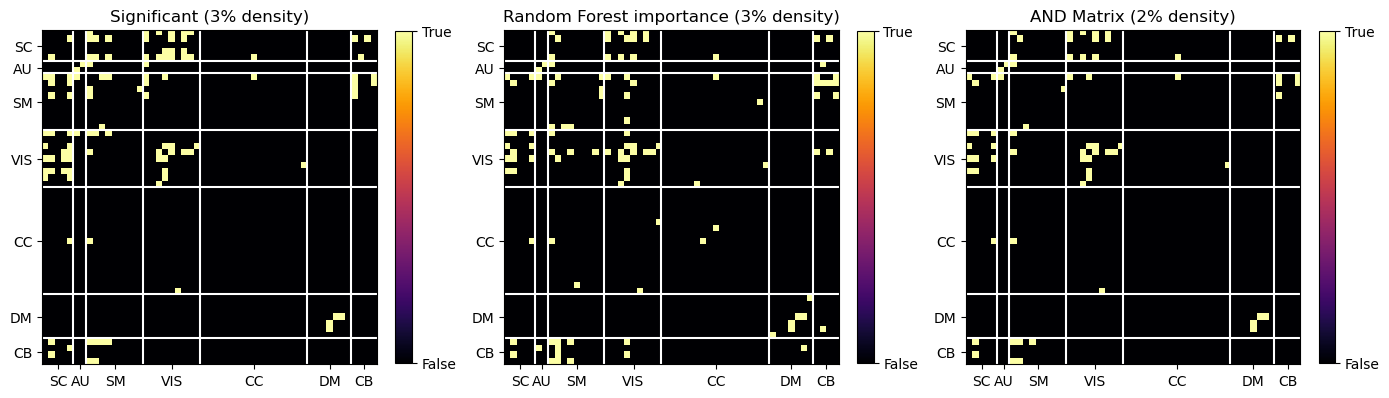

Analyzing SPI: cov-sq_GraphicalLasso


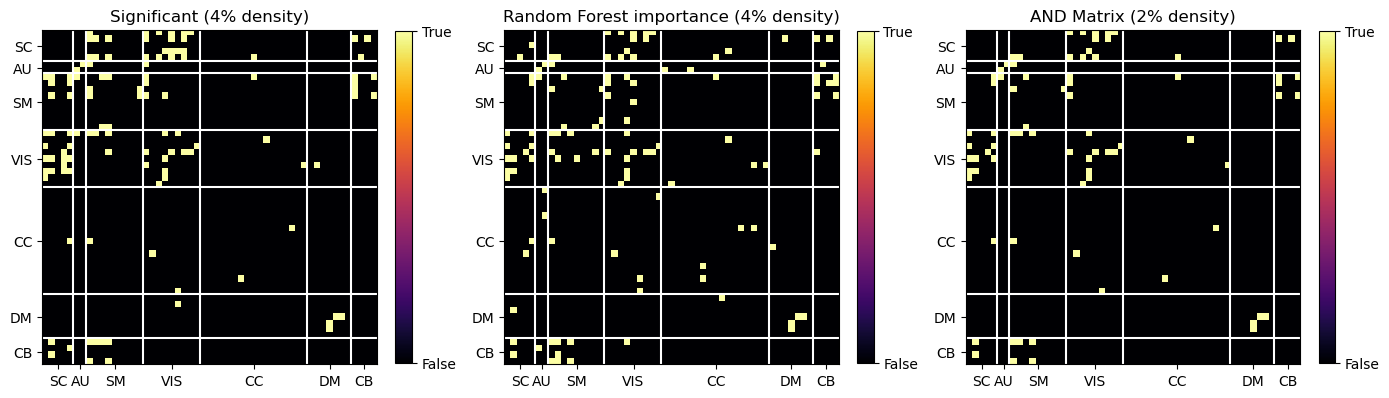

Analyzing SPI: cov-sq_GraphicalLassoCV


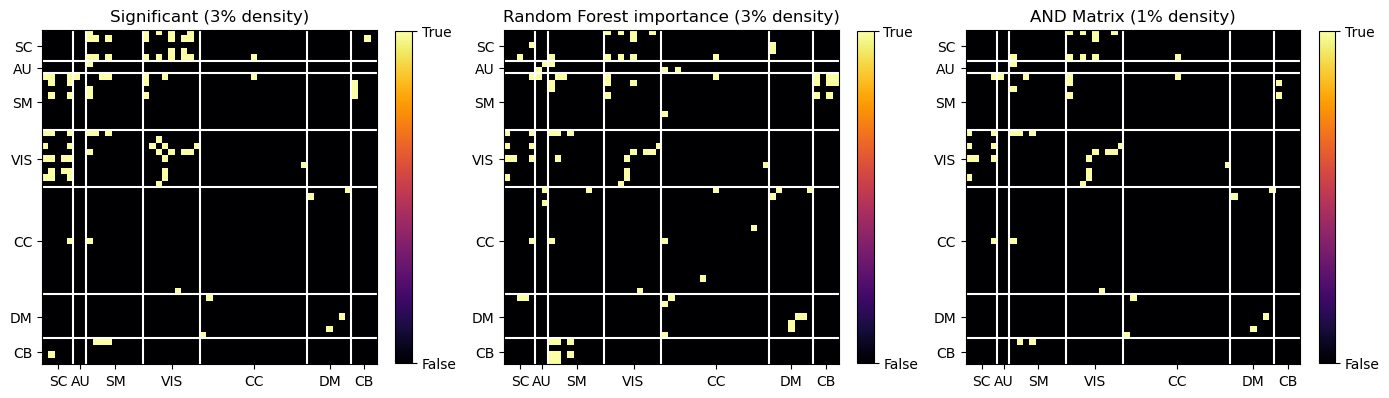

Analyzing SPI: cov-sq_LedoitWolf


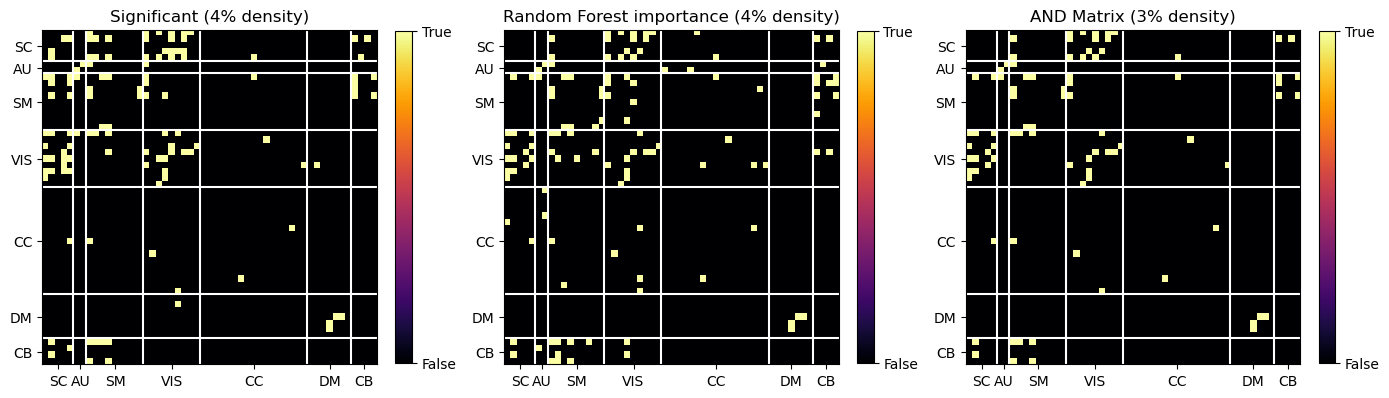

Analyzing SPI: cov-sq_MinCovDet


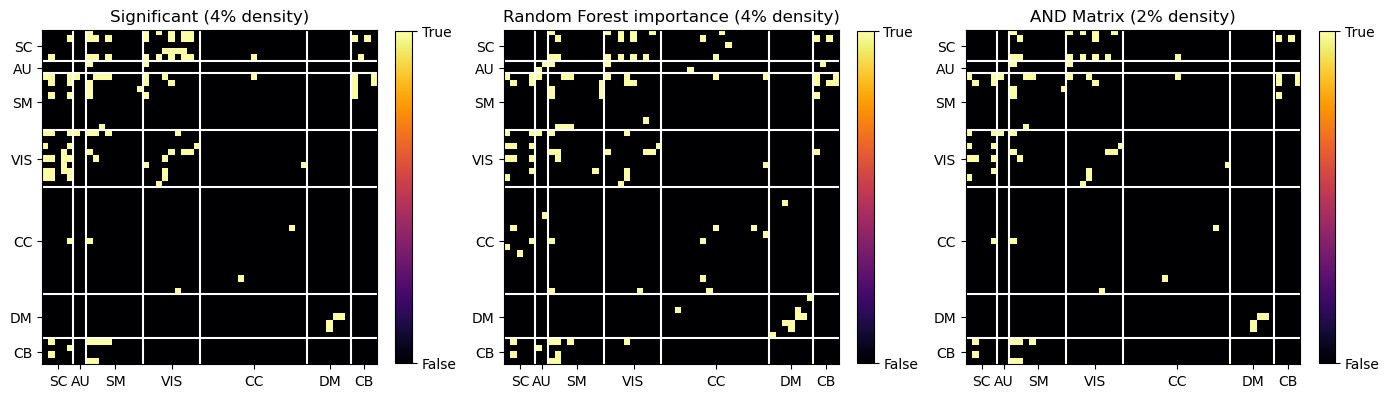

Analyzing SPI: cov-sq_OAS


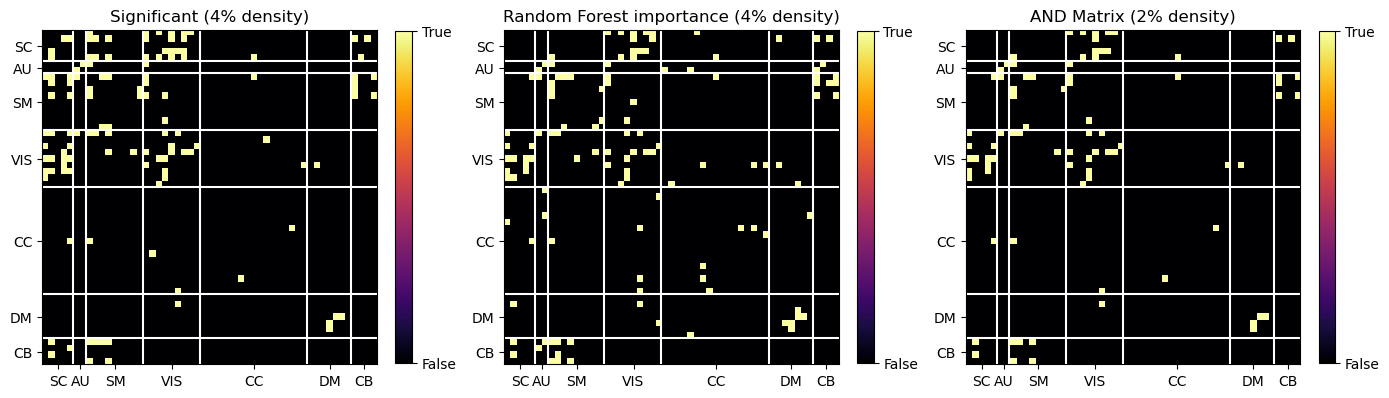

Analyzing SPI: cov-sq_ShrunkCovariance


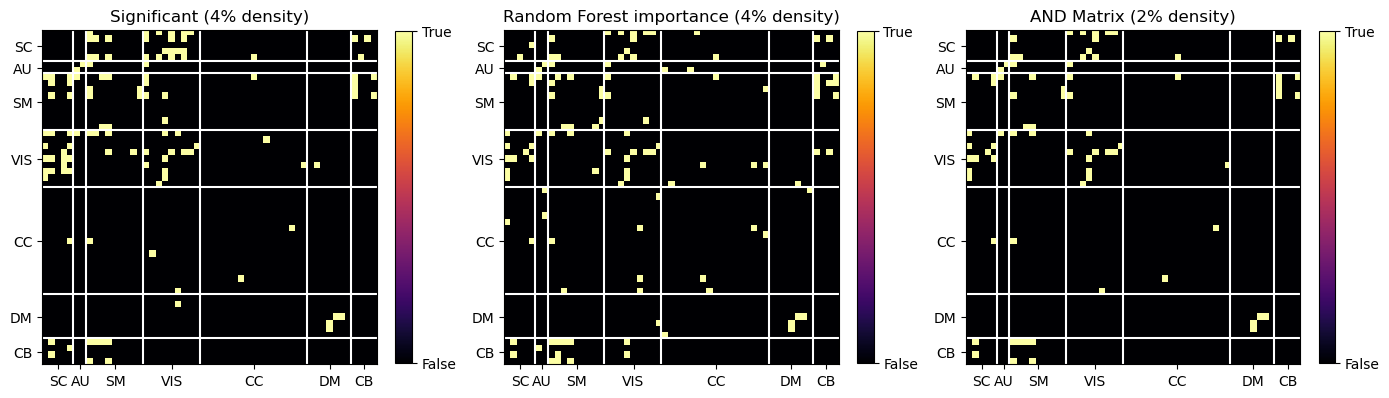

Analyzing SPI: prec_EmpiricalCovariance


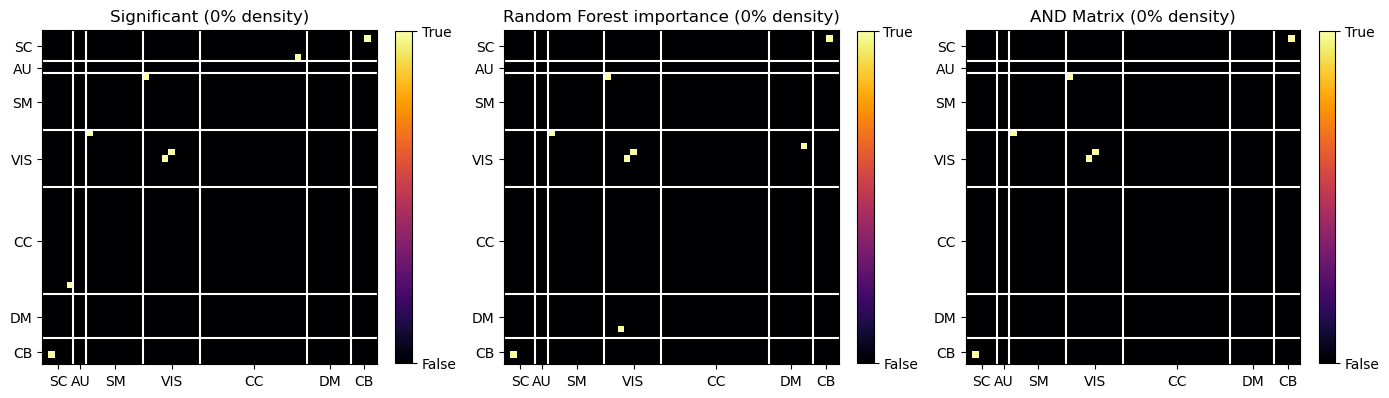

Analyzing SPI: prec_EllipticEnvelope


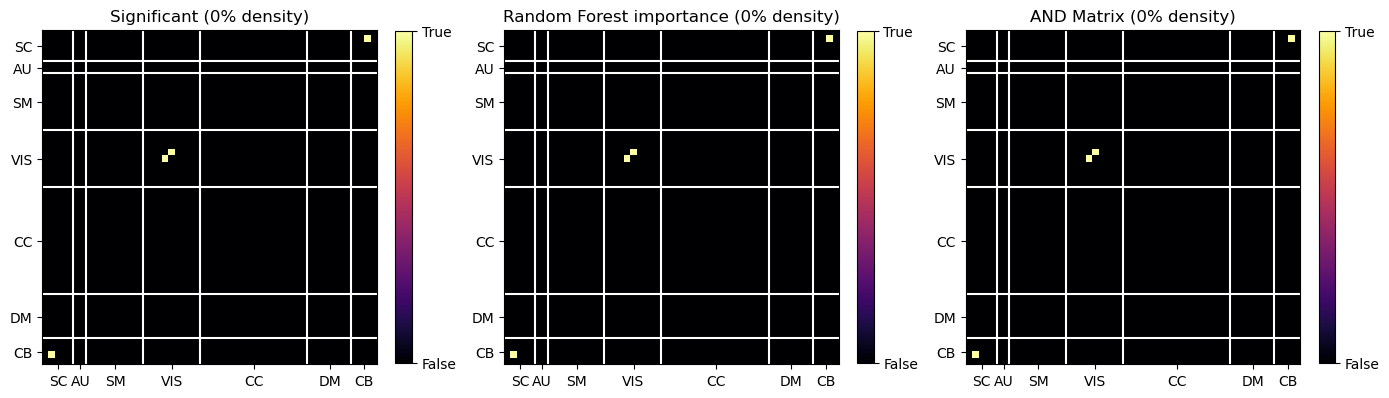

Analyzing SPI: prec_GraphicalLasso


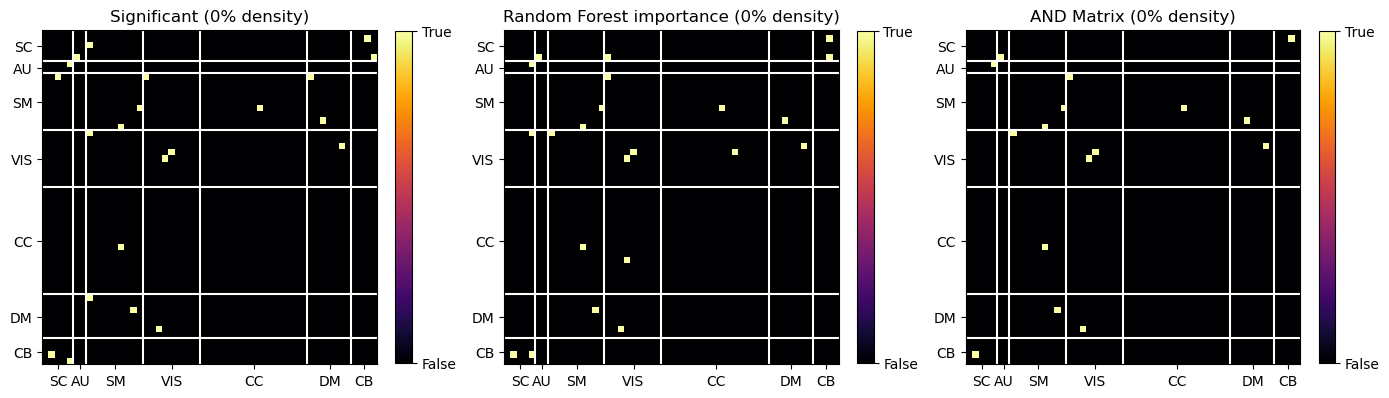

Analyzing SPI: prec_GraphicalLassoCV


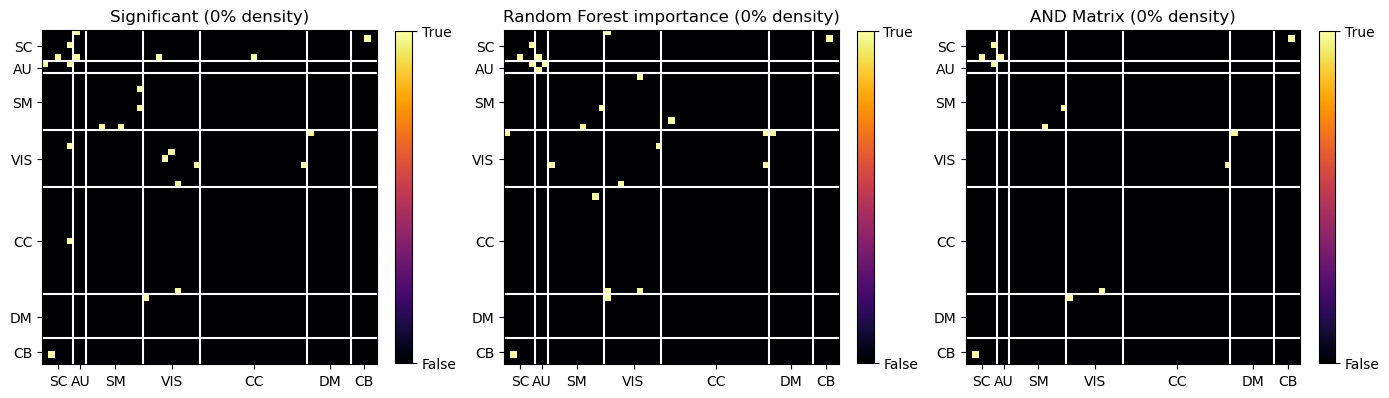

Analyzing SPI: prec_LedoitWolf


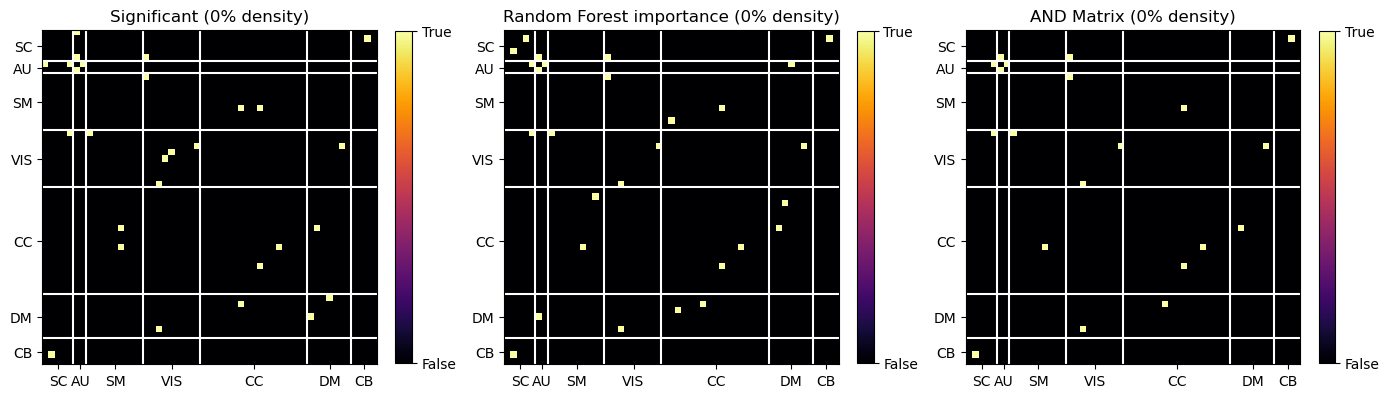

Analyzing SPI: prec_MinCovDet


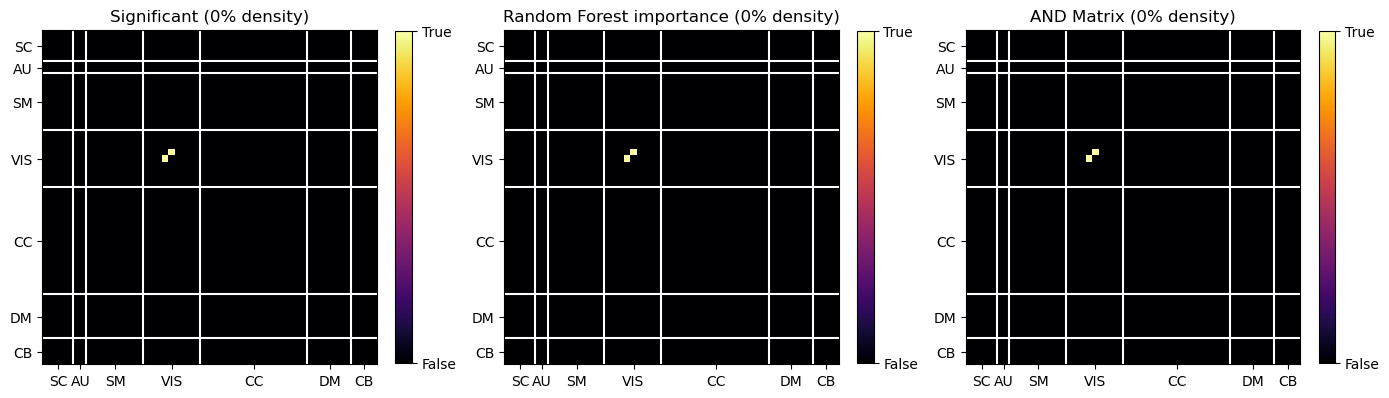

Analyzing SPI: prec_OAS


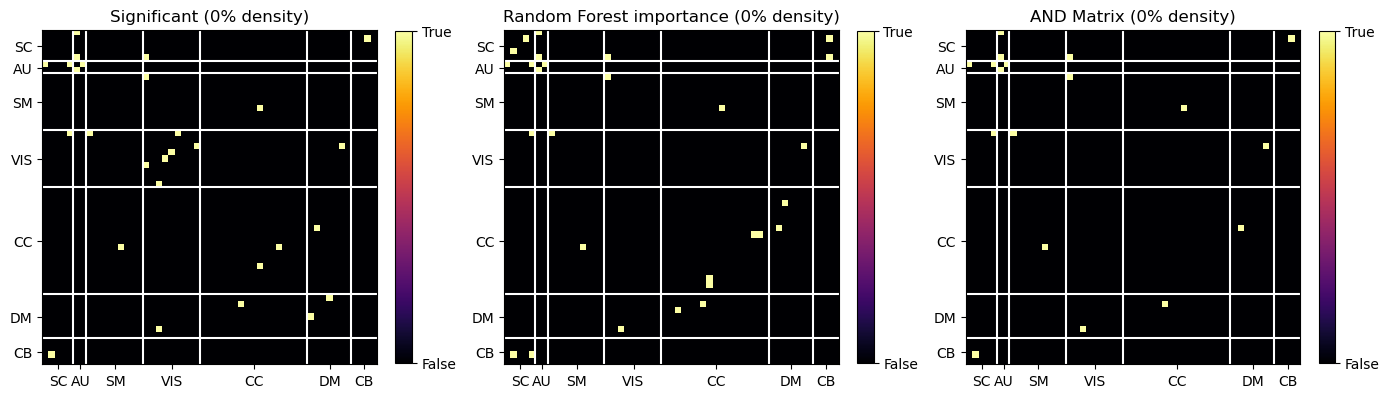

Analyzing SPI: prec_ShrunkCovariance


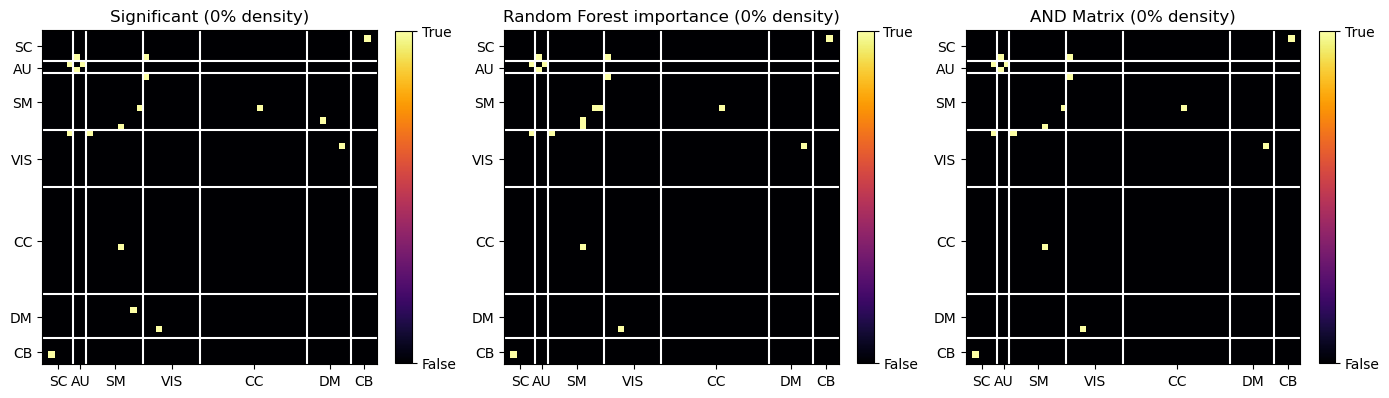

Analyzing SPI: spearmanr-sq


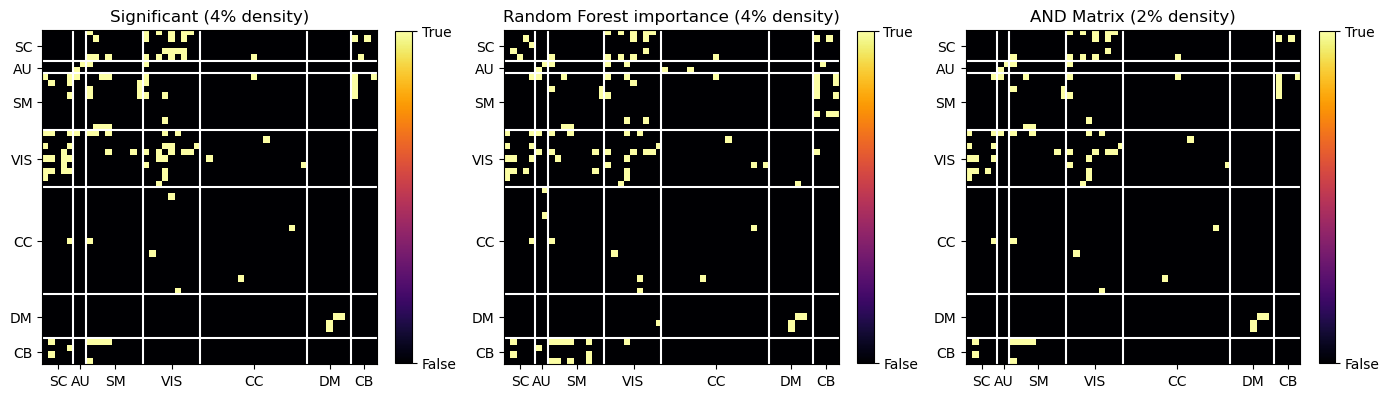

Analyzing SPI: spearmanr


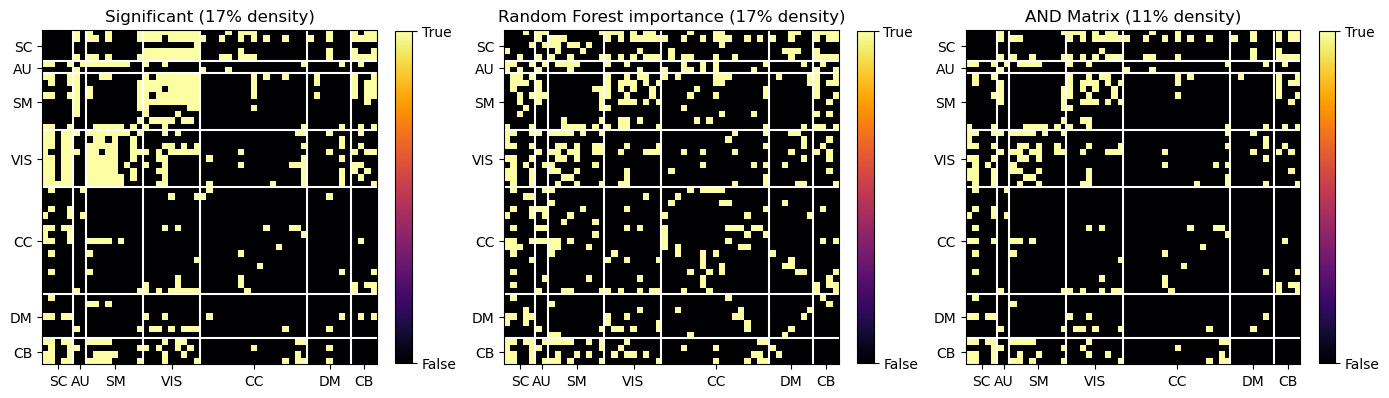

Analyzing SPI: kendalltau-sq


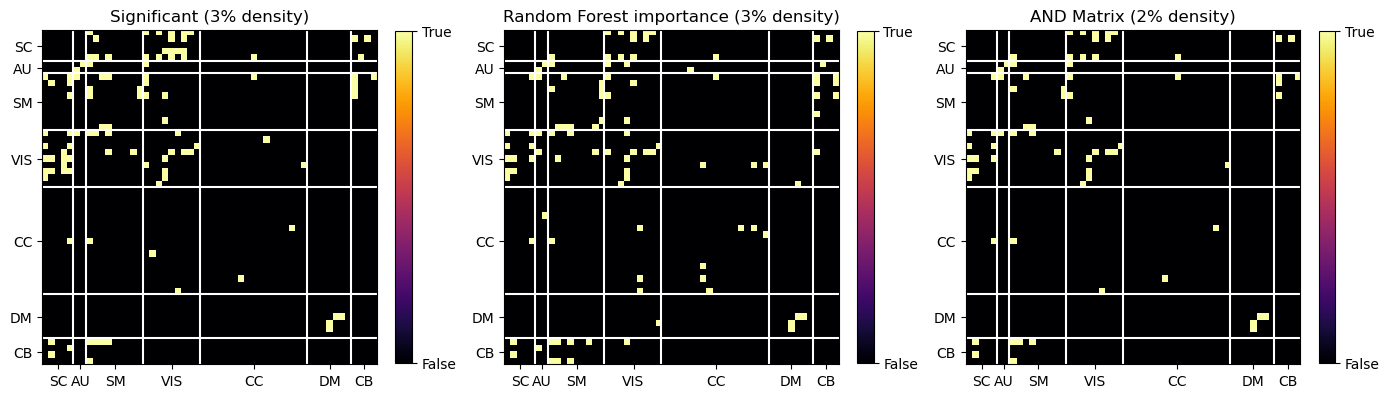

Analyzing SPI: kendalltau


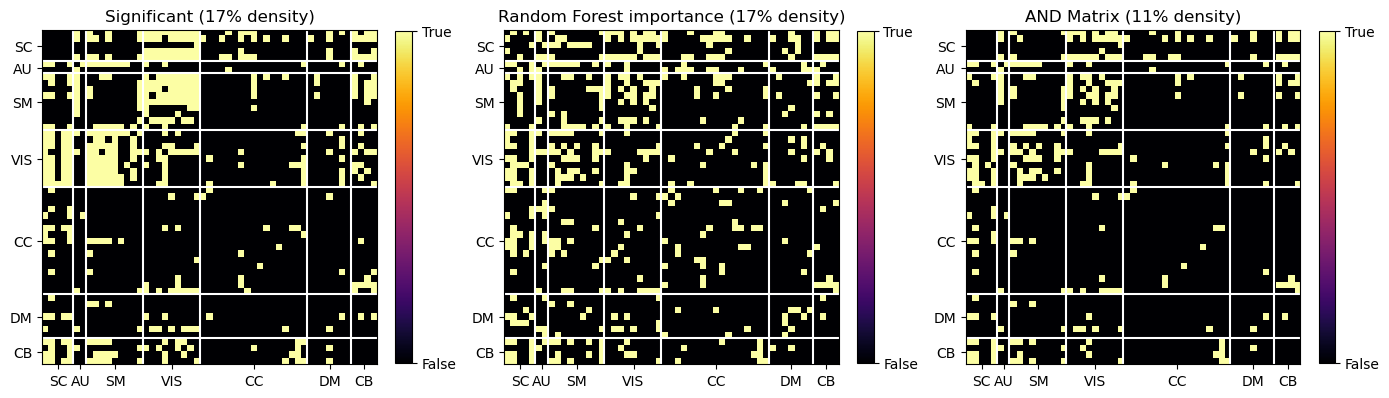

Analyzing SPI: xcorr_mean_sig-True


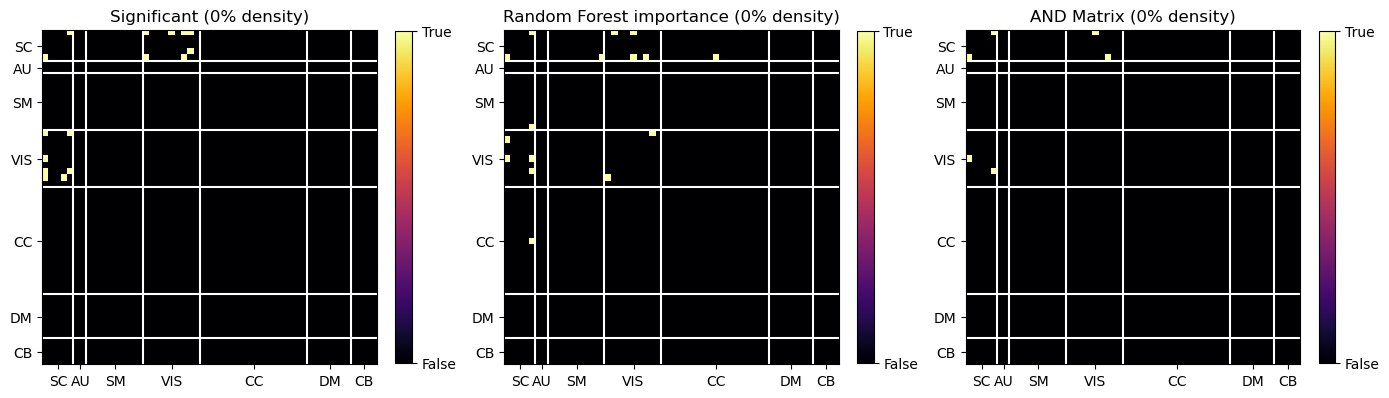

Analyzing SPI: xcorr-sq_mean_sig-True


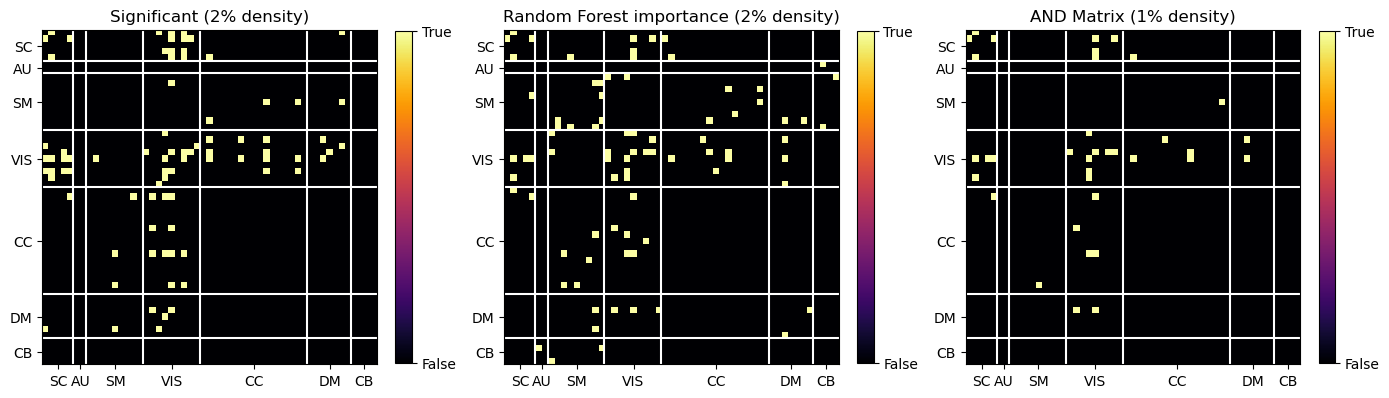

Analyzing SPI: xcorr-sq_mean_sig-False


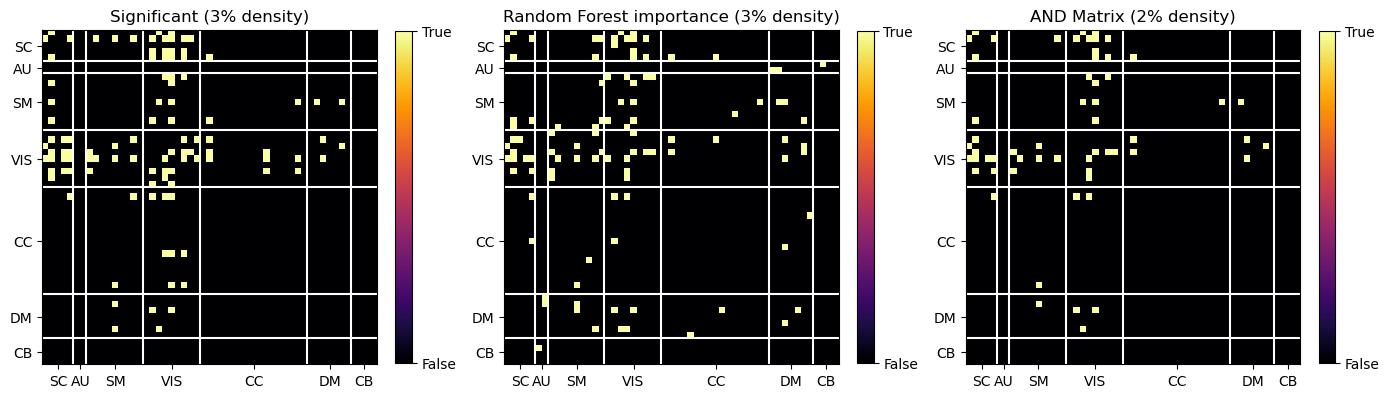

Analyzing SPI: dcorr


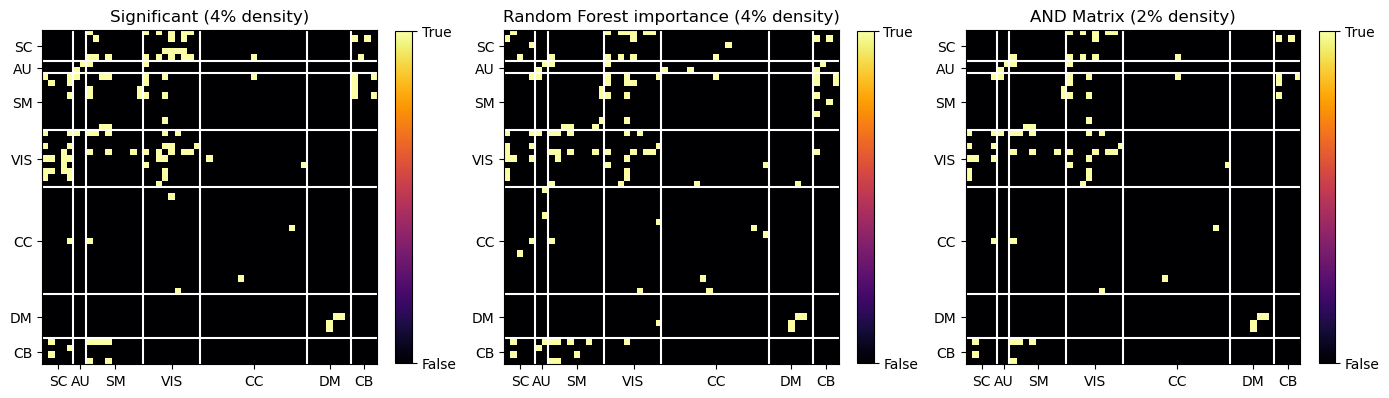

Analyzing SPI: mgc


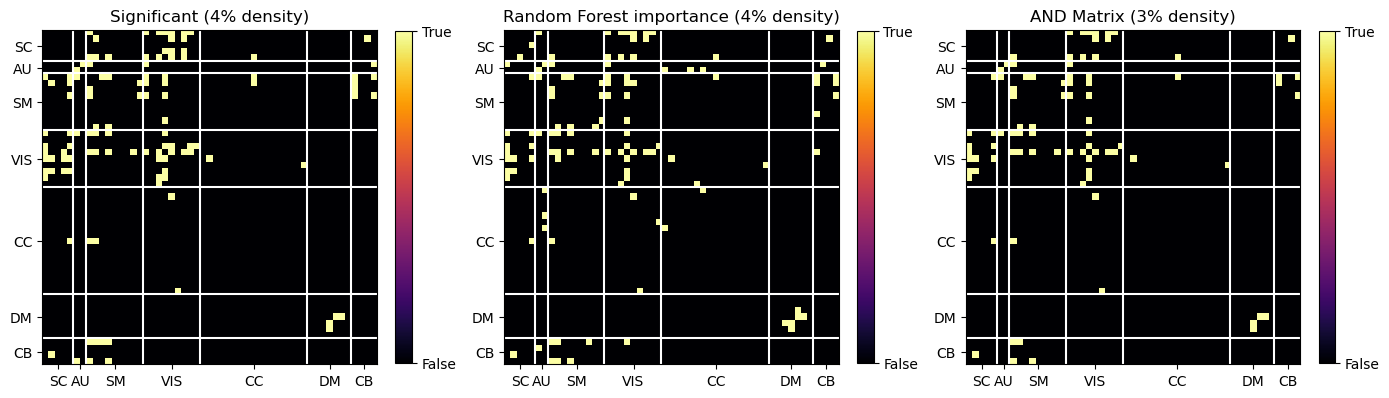

Analyzing SPI: hsic


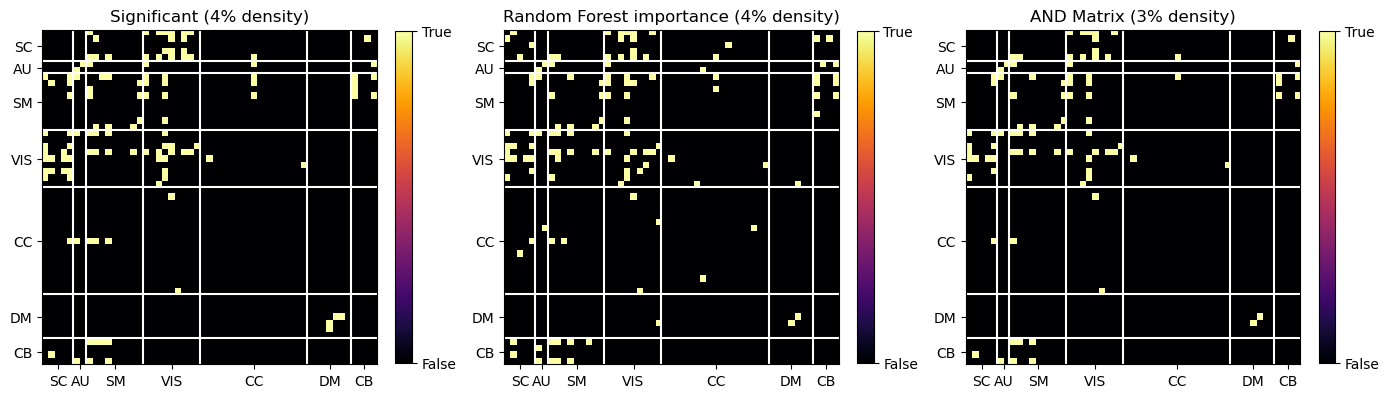

Analyzing SPI: dcorrx_maxlag-1


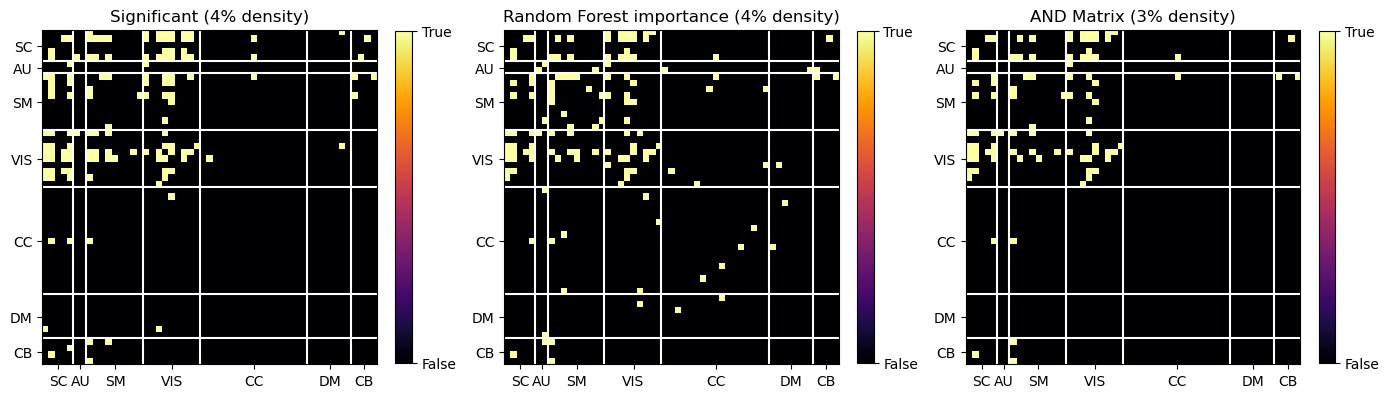

Analyzing SPI: pec


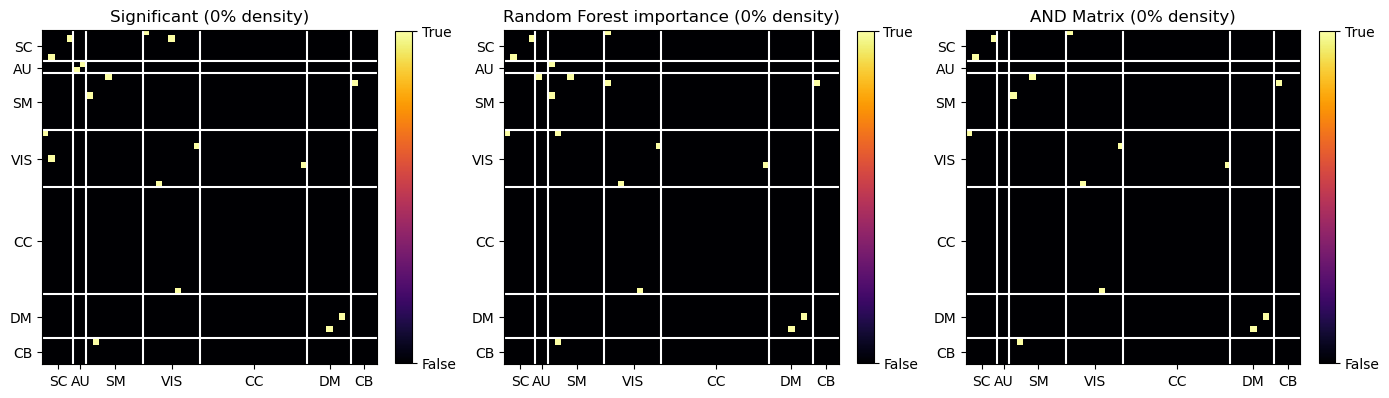

Analyzing SPI: pec_log


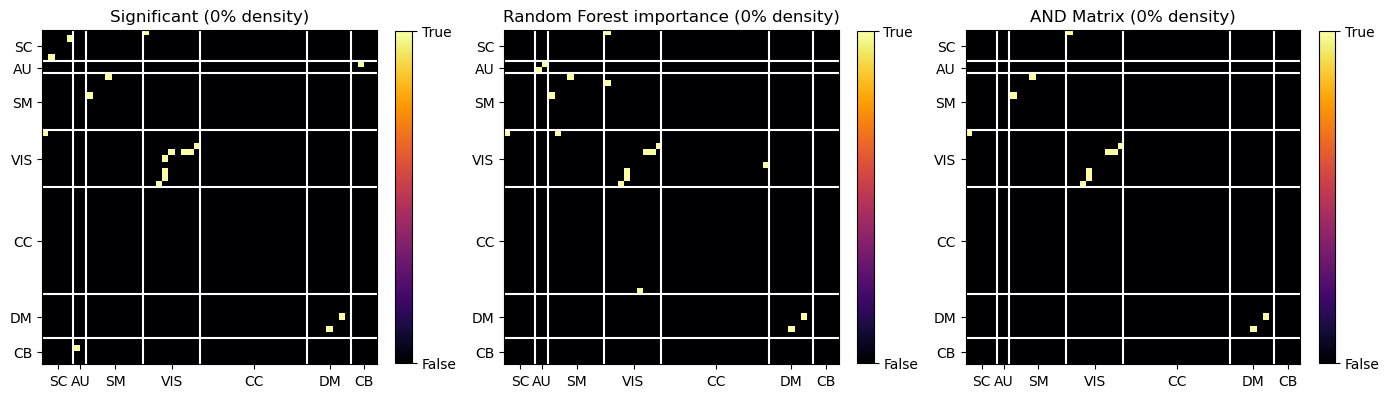

In [18]:
# inspect all SPI stats
for spi in DATA["spis"]:
    print(f"Analyzing SPI: {spi}")
    stat = STATS[spi]["stat"]
    p_value = STATS[spi]["p_value"]
    p_thresh = STATS[spi]["p_thresh"]

    importances = STATS[spi]["importances"]
    importance_mask = STATS[spi]["importance_mask"]
    r_significant = STATS[spi]["r_significant"]
    
    # plot_stats(stat, p_value, p_thresh, title=spi)
    # plot_importances(importances, importance_mask)
    plot_and_matrix(p_thresh, importance_mask)
    # break

In [22]:
# average covariance, squared covariance and precisions stats
PROC_STATS = {}

families = ["cov_", "cov-sq_", "prec_"]
for spi_family in families:
    
    target_data = []
    for spi in DATA["spis"]:
        if spi.startswith(spi_family):
            target_data.append(STATS[spi])

    new_spi = {}
    new_spi["p_thresh"] = np.mean([d["p_thresh"].astype(int) for d in target_data], axis=0)
    new_spi["importance_mask"] = np.mean([d["importance_mask"].astype(int) for d in target_data], axis=0)
    PROC_STATS[f"{spi_family[:-1]}"] = new_spi

for spi in DATA["spis"]:
    # print(spi)
    if not any([spi.startswith(family) for family in families]):
        PROC_STATS[spi] = {
            "p_thresh": STATS[spi]["p_thresh"],
            "importance_mask": STATS[spi]["importance_mask"]
        }

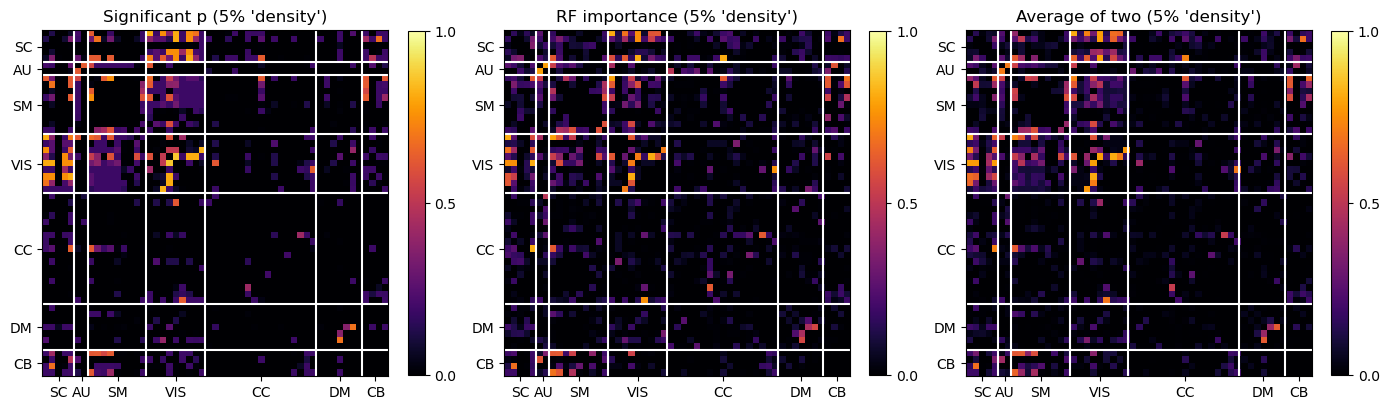

In [38]:
# inspect all processed SPI stats
p_threshs, importance_masks = [], []
for spi in PROC_STATS:
    p_threshs.append(PROC_STATS[spi]["p_thresh"].astype(float))
    importance_masks.append(PROC_STATS[spi]["importance_mask"].astype(float))

p_thresh = np.mean(np.array(p_threshs), axis=0)
importance_mask = np.mean(np.array(importance_masks), axis=0)
plot_and_matrix(p_thresh, importance_mask, aggregated=True)

# for spi in PROC_STATS:
#     print(f"Analyzing SPI: {spi}")
#     p_thresh = PROC_STATS[spi]["p_thresh"]
#     importance_mask = PROC_STATS[spi]["importance_mask"]
    
#     # plot_stats(stat, p_value, p_thresh, title=spi)
#     # plot_importances(importances, importance_mask)
#     if spi in [family[:-1] for family in families]:
#         plot_and_matrix(p_thresh, importance_mask, aggregated=True)
#     else:
#         plot_and_matrix(p_thresh, importance_mask)
#     # break
